# Baseline: CNN for Lidar Odometry

In [1]:
#setup
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio

#need to have these two lines to work on my ancient 1060 3gb
#  https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180
# %matplotlib notebook



Autosaving every 180 seconds


In [2]:
# file = "data/train_10k.npy" #has noise in readings
# file = "data/train_100k.npy" #no noise
# file = "data/train_straight_1k.npy" #no noise, no lateral movement relative to initial heading
file = "data/train_dxdy_100k.npy" #no noise, displacement in x and y relative to starting orientation

dataset = np.load(file)

In [ ]:
#combine 100k and 200k datasets
# ds2 = np.load("data/train_dxdy_100k.npy")
# dataset = np.append(dataset, ds2, axis =0)
# np.save("data/train_dxdy_300k.npy", dataset)

In [ ]:
dataset[0,100:]
np.shape(dataset)

In [ ]:
# dataset[100,:]

In [ ]:
from network import Net1, Net2

np.random.seed(1337)

#convert data from numpy to tensors
# x_train = tf.convert_to_tensor(dataset[:,:100])

#alternate dataset where we are just looking at the changes in measurement from the first sample to the 2nd
x_temp = tf.convert_to_tensor(dataset[:,:100])
x_train = np.zeros([np.shape(dataset)[0], 50])
x_train[:,:50] = x_temp[:,:50] - x_temp[:,50:100]

print(np.shape(x_train))

y_train = tf.convert_to_tensor(dataset[:,100:])

In [ ]:
model = Net1() # 50 input data (looking at differences in measurememnt between each point) 
# model = Net2() # 100 input network (looking at full data)

runLen = 30    
BS = 128 #256 #works well

def scheduler(epoch, lr):
    part1 = 2*runLen//3
    part2 = 5*runLen//6

#     part1 = runLen//3
#     part2 = 2*runLen//3

    if epoch < part1:
        lr = 0.01
        return lr
    if epoch >= part1 and epoch < part2:
        lr = 0.005
        return lr
    if epoch >= part2:
        lr = 0.001
        return lr

#TODO: figure out how to implement sample weight
# L = tf.keras.losses.MeanAbsoluteError()
# sample_weight = [0.3,0.3,0.4]
    
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
#     loss=tf.keras.losses.MeanSquaredError(),
    loss=tf.keras.losses.MeanAbsoluteError(),
#     loss = tf.keras.losses.MeanAbsolutePercentageError(),
)

summary = model.summary()
print(summary)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

trace = model.fit(x=x_train, y=y_train, batch_size=BS, epochs=runLen, verbose=1, 
                  validation_split=0.05, callbacks = [callback], shuffle=True)


In [ ]:
model = tf.keras.models.load_model('dead_reckoning_1pt22_mse.kmod')

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(trace.history['loss'], '-')
plt.plot(trace.history['val_loss'], '-')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('iteration')
plt.ylabel('loss')

In [ ]:
r = int(np.random.rand()*100)
print(y_train[r])
out = model.predict(x_train[:100])
print(out[r])

In [ ]:
test_file = "data/test_dxdy.npy"
test_dataset = np.load(test_file)
rand = int(np.shape(test_dataset)[0]*np.random.rand())

#test for standard case
# x_test = test_dataset[:,:100]
# x_test = tf.convert_to_tensor(x_test)

#test when looking at displacement between two measurements
x_temp2 = tf.convert_to_tensor(test_dataset[:,:100])
x_test = np.zeros([np.shape(test_dataset)[0], 50])
x_test[:,:50] = x_temp2[:,:50] - x_temp2[:,50:100]

y_test = test_dataset[:,100:]
y_test = tf.convert_to_tensor(y_test)
# print(y_test[rand])
print(y_train[rand])

# guess = model.predict(x_test)
guess = model.predict(x_train)
print(guess[rand])

In [ ]:
# model.save("dead_reckoning_1pt22_mse.kmod") #got this with 50 input model

Results:

Best MSE with 100k dataset: 1.36

Best MSE with 300k dataset: 1.22

## Generate Normal Distribution Ellipse

In [3]:
# %matplotlib notebook
from utils import fit_gaussian

numpts = 10
points = np.random.randn(numpts, 2)

#adds order to points
points[:,0] += np.linspace(1,10,numpts)
points[:,1] += np.linspace(0,5*np.random.randn(),numpts)
 
mu, sigma = fit_gaussian(points)
print("mu = ", mu)
print("sigma = ", sigma)

eig = np.linalg.eig(sigma)
eigenval = eig[0]
eigenvec = eig[1]

print("eigenval = ", eigenval)
print("eigenvec = ", eigenvec)


mu =  [ 5.28930001 -0.21902702]
sigma =  [[ 9.55989030e+00 -7.11091840e-03]
 [-7.11091840e-03  7.15283201e-01]]
eigenval =  [9.55989602 0.71527748]
eigenvec =  [[ 9.99999677e-01  8.03982746e-04]
 [-8.03982746e-04  9.99999677e-01]]


In [4]:
from utils import R
# print(eigenvec)
theta_temp = np.arcsin(eigenvec[0,1]/eigenvec[0,0])
print(theta_temp)
# print(R(theta_temp))
# print(R(np.arctan(eigenvec[0,1]/eigenvec[0,0])))

0.0008039830923852526


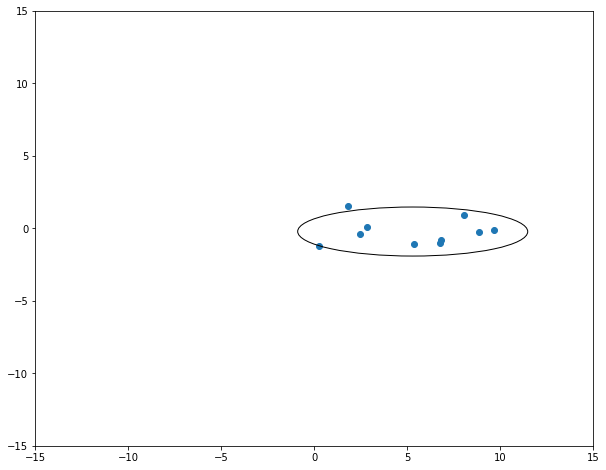

In [5]:
#draw ellipse around 1std to prove fit_guassian works
from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches 

nstd = 2

fig2 = plt.figure(1)
ax2 = fig2.add_subplot()

patches = []

ax2.set_xlim(-15,15)
ax2.set_ylim(-15,15)
ax2.scatter(points[:,0], points[:,1])

rot = -np.rad2deg(np.arcsin(eigenvec[0,1]/eigenvec[0,0]))
width = 2*nstd*np.sqrt(eigenval[0])
height = 2*nstd*np.sqrt(eigenval[1])

ell = Ellipse((mu[0],mu[1]),width, height, angle = rot, fill = False)
ax2.add_patch(ell)


## Best fit ellipses directly on dataset

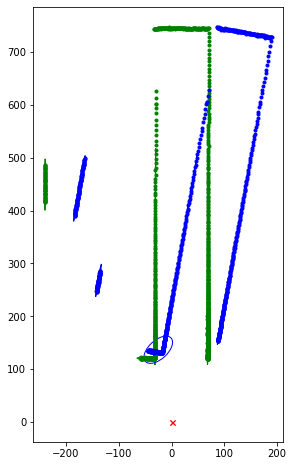

In [6]:
from utils import draw_scan, subdivide_scan

fig3 = plt.figure(1)
ax3 = fig3.add_subplot()
ax3.set_aspect('equal')
rand2 = int(np.random.rand()*50) #82 is a simple corner, 2 is a doorway
# print(rand2)

# dat = np.load("data/noisy_dxdy_100.npy") #only 50 very noisy data points
scanpts = 1000
dat = np.load("data/high_res_noisy_dxdy_100.npy") #what I had been using
# dat = np.load("data/cross_track.npy")   #new dataset

dat1 = dat[:,:scanpts]
dat2 = dat[:,scanpts:2*scanpts]

rand2 = 2 #easy test (moving away from corner)

#get point positions and draw lidar scan
pp1 = draw_scan(dat1[rand2],fig3,ax3, pt = 0) #pt0
pp2 = draw_scan(dat2[rand2],fig3,ax3, pt = 1) #pt1

f = 25 #overall region of scan is broken down into a fxf scan
E1 = subdivide_scan(pp1,fig3,ax3, nstd = 3, fidelity = f, pt =0)
E2 = subdivide_scan(pp2,fig3,ax3, nstd = 3, fidelity = f, pt =1)

# green = before
# blue = after

Note: stretched ellipses mean cov matrix is getting close to singular

## Vanilla ICP with SVD

center_q  [14.5         0.28272719]
center_p  [ 7.92122511 15.32106173]
center_p  [14.5         0.28272719]
center_p  [14.5         0.28272719]
center_p  [14.5         0.28272719]
R:  [[ 0.99976764  0.02155619]
 [-0.02155619  0.99976764]]
t:  [-0.00272528  0.31263051]


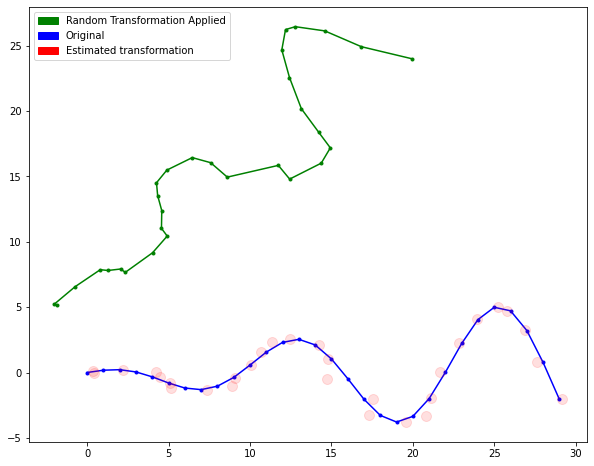

In [7]:
from ICP import vanilla_ICP
fig4 = plt.figure(1)
ax4 = fig4.add_subplot()
blue = mpatches.Patch(color='blue', label='Original')
green = mpatches.Patch(color='green', label='Random Transformation Applied')
red = mpatches.Patch(color='red', label='Estimated transformation')
plt.legend(handles=[green, blue, red])

#create dummy data
angle = np.pi / 4
R_true = np.array([[np.cos(angle), -np.sin(angle)], 
                   [np.sin(angle),  np.cos(angle)]])
t_true = np.array([[-2], [5]])

# Generate data as a list of 2d points
num_points = 30
true_data = np.zeros((2, num_points))
true_data[0, :] = range(0, num_points)
true_data[1, :] = 0.2 * true_data[0, :] * np.cos(0.5 * true_data[0, :]) 
# Move the data
moved_data = R_true.dot(true_data) + t_true + 0.5*np.random.randn(num_points) #roate and add noise
# moved_data = moved_data[:,8:] #cut move dataset short
# moved_data[:, 0] = np.array([-20,5]) #create outliar at start

# Assign to variables we use in formulas.
Q = true_data
P = moved_data

green, = ax4.plot(P[0,:],P[1,:], 'g.-')
blue, = ax4.plot(Q[0,:], Q[1,:], 'b.-')


dc = False     #display correspondences
nc = 4    #number of cycles
R, t = vanilla_ICP(Q,P,fig4,ax4,draw=dc,num_cycles = nc)

print("R: ", R)
print("t: ", t)

## Apply vanilla ICP function with SVD to a noisy dataset. 
As predicted, results are not great.

center_q  [ 12.50723532 336.43792021]
center_p  [1.69483429e-01 3.12211442e+02]
center_p  [ 12.50723532 336.43792021]
center_p  [ 12.50723532 336.43792021]
R:  [[ 0.99996815  0.00798074]
 [-0.00798074  0.99996815]]
t:  [-2.6846257   0.11053142]


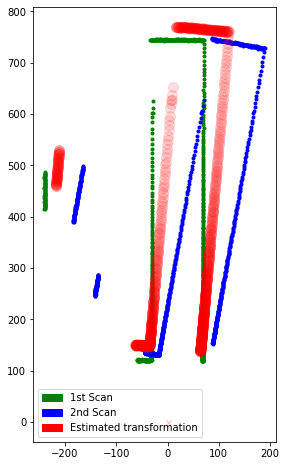

In [8]:
fig5 = plt.figure(1)
ax5 = fig5.add_subplot()
ax5.set_aspect('equal')

dc2 = False
nc2 = 3 #number of cycles

# rand3 = int(np.random.rand()*100)
rand3 = 2 #easy test
pp1 = draw_scan(dat1[rand3],fig5,ax5, pt = 0) 
pp2 = draw_scan(dat2[rand3],fig5,ax5, pt = 1)

R, t = vanilla_ICP(pp2.T,pp1.T,fig5,ax5,draw=dc2,num_cycles = nc2)
print("R: ", R)
print("t: ", t)

green = mpatches.Patch(color='green', label='1st Scan')
blue = mpatches.Patch(color='blue', label='2nd Scan')
red = mpatches.Patch(color='red', label='Estimated transformation')
plt.legend(handles=[green, blue, red])

## Apply Vanilla ICP to normal distribution ellipses

3  ellipses from first scan
5  ellipses from 2nd scan
center_q  [-14.07732398 277.65429481]
center_p  [-17.77927857 278.19342054]
R =  [[ 0.99905683 -0.04342167]
 [ 0.04342167  0.99905683]]
t =  [15.76480905  0.4952627 ]


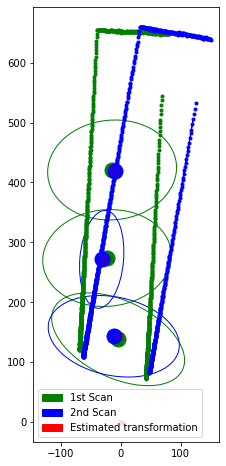

In [9]:
fig6 = plt.figure(1)
ax6 = fig6.add_subplot()
ax6.set_aspect('equal')
rand2 = int(np.random.rand()*9) #82 is a simple corner, 2 is a doorway
green = mpatches.Patch(color='green', label='1st Scan')
blue = mpatches.Patch(color='blue', label='2nd Scan')
red = mpatches.Patch(color='red', label='Estimated transformation')
plt.legend(handles=[green, blue, red])

# rand2 = 33 #easy test (moving away from corner)

#get point positions and draw lidar scan
pp1 = draw_scan(dat1[rand2],fig6,ax6, pt = 0) 
pp2 = draw_scan(dat2[rand2],fig6,ax6, pt = 1) 

f = 8 #overall region of scan is broken down into a fxf scan
E1 = subdivide_scan(pp1,fig6,ax6, fidelity = f, pt =0)
E2 = subdivide_scan(pp2,fig6,ax6, fidelity = f, pt =1)

print(len(E1), " ellipses from first scan")
print(len(E2), " ellipses from 2nd scan")

#loop through outputs to get coords of std ellipses
s1 = np.zeros([len(E1),2])
for count, i in enumerate(E1):
    s1[count] = i[0]
s2 = np.zeros([len(E2),2])
for count, i in enumerate(E2):
    s2[count] = i[0] 

if len(s1) > len(s2):
    s1 = s1[:len(s2)]
if len(s2) > len(s1):
    s2 = s2[:len(s1)]

ax6.plot(s1[:,0],s1[:,1],'g.', markersize = 30)
ax6.plot(s2[:,0],s2[:,1],'b.', markersize = 30)
    
dc3 = False
nc3 = 1 
R, t = vanilla_ICP(s1.T,s2.T,fig6,ax6,draw=dc3,num_cycles = nc3)
print("R = ", R)
print("t = ", t)

Notes:

SVD seems to translate only on the first iteration, least squares approach will update translation estimate after each iteration

error analysis more difficult on NDT

what to do about features only detected in 2nd scan?
    after n iterations of ICP, remove features with higest error, continue calculating. 
        If performance improves, these features should remain removed, else put them back in


## Least Squares ICP

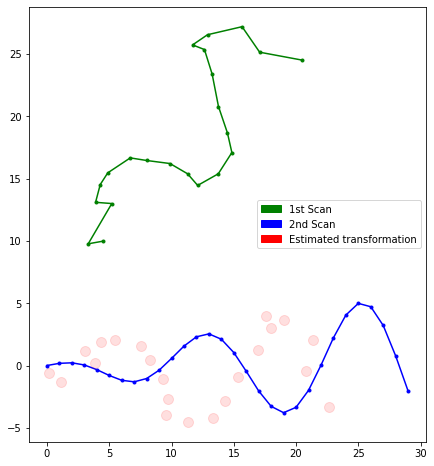

In [10]:
from  ICP import ICP_least_squares
fig7 = plt.figure(1)
ax7 = fig7.add_subplot()
ax7.set_aspect('equal')
rand2 = int(np.random.rand()*50) #82 is a simple corner, 2 is a doorway
green = mpatches.Patch(color='green', label='1st Scan')
blue = mpatches.Patch(color='blue', label='2nd Scan')
red = mpatches.Patch(color='red', label='Estimated transformation')
plt.legend(handles=[green, blue, red])

#create dummy data
angle = np.pi / 4
R_true = np.array([[np.cos(angle), -np.sin(angle)], 
                   [np.sin(angle),  np.cos(angle)]])
t_true = np.array([[-2], [5]])

# Generate data as a list of 2d points
num_points = 30
true_data = np.zeros((2, num_points))
true_data[0, :] = range(0, num_points)
true_data[1, :] = 0.2 * true_data[0, :] * np.cos(0.5 * true_data[0, :]) 
# Move the data
moved_data = R_true.dot(true_data) + t_true + .5*np.random.randn(num_points) #roate and add noise
moved_data = moved_data[:,8:] #cut move dataset short
# moved_data[:, 0] = np.array([-20,5]) #create outliar at start

# Assign to variables we use in formulas.
Q = true_data
P = moved_data

green, = ax7.plot(P[0,:],P[1,:], 'g.-')
blue, = ax7.plot(Q[0,:], Q[1,:], 'b.-')


NC = 10
P_corrected = ICP_least_squares(Q,P,fig7,ax7, num_cycles = NC, draw = False)

Notes about Least Squares:

Less susceptable to initial conditions

capable of working with inconsistant datasets (ex: |P| = 15, |Q| = 20)

more dependant on outliars?

### Applying Least Squares to lidar scan dataset

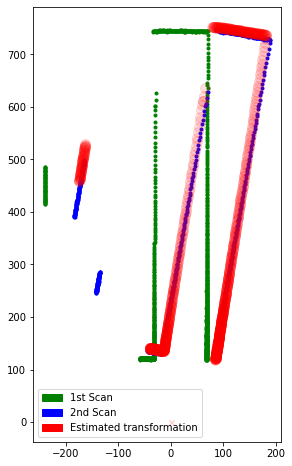

In [11]:
fig8 = plt.figure()
ax8 = fig8.add_subplot()
ax8.set_aspect('equal')
green = mpatches.Patch(color='green', label='1st Scan')
blue = mpatches.Patch(color='blue', label='2nd Scan')
red = mpatches.Patch(color='red', label='Estimated transformation')
plt.legend(handles=[green, blue, red])

# rand3 = int(np.random.rand()*100)
# print("scan #: ", rand3)
rand3 = 2 #or 33 for easy test
pp1 = draw_scan(dat1[rand3],fig8,ax8, pt = 0) 
pp2 = draw_scan(dat2[rand3],fig8,ax8, pt = 1)


dc = False
nc = 10 #number of cycles
P_corrected, t, rot = ICP_least_squares(pp2.T,pp1.T,fig8,ax8, num_cycles = nc, draw = dc)
# print("t = ", t)
# print("rot = ", rot)

#### Notes:
good accuracy but SLOW

# Normal Distribution Transform (NDT)

Estimated transformation 
 [[-1.87368618e+01 -1.15869102e+02 -4.84802005e-02]]
Actual transformation: 
 [ 20.73619473 -19.56584081   0.07437485]
error: 
 [[ 1.99933295e+00 -1.35434943e+02  2.58946504e-02]]


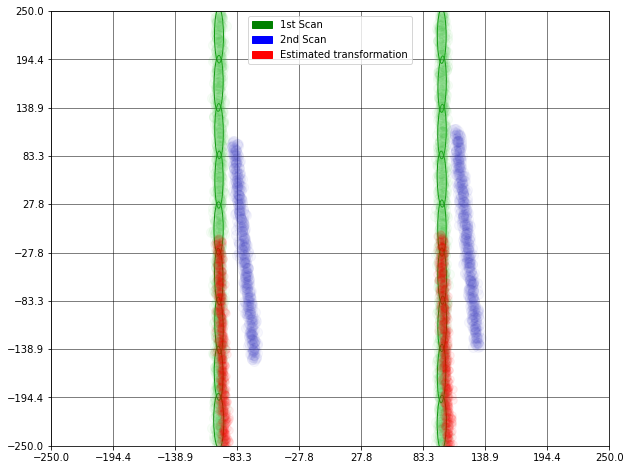

In [2337]:
# from NDT import NDT_old as NDT
from NDT import NDT

fig9 = plt.figure()
ax9 = fig9.add_subplot()
# ax9.set_xlim(-125,150)
green = mpatches.Patch(color='green', label='1st Scan')
blue = mpatches.Patch(color='blue', label='2nd Scan')
red = mpatches.Patch(color='red', label='Estimated transformation')
plt.legend(handles=[green, blue, red])

# a = int(100*np.random.rand())
# print(a)
a = 59 #59 #10 #97 #33 #easy test scans
fidelity = 10 # [N x N] grid of ellipses
nc = 100  # number of cycles
atd = True #along track demo

r, t, results, x_actual = NDT(dat1[a],dat2[a],fig9,ax9, fid = fidelity, 
                              num_cycles = nc, along_track_demo = atd,
                             output_actual = True)
x_est = np.array([t[0], t[1], r]).T
print("Estimated transformation \n", np.array(x_est))
print("Actual transformation: \n", x_actual)
print("error: \n", x_est + x_actual)

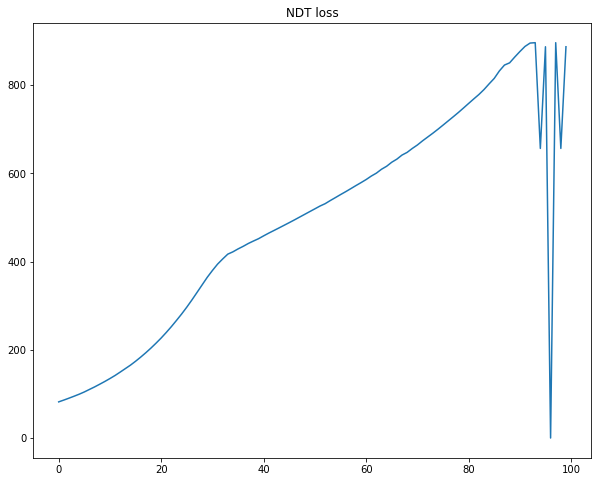

In [2338]:
fig10 = plt.figure()
ax10 = fig10.add_subplot()
ax10.set_title("NDT loss")

ax10.plot(results)

# NDT Monte-Carlo Sim

KeyboardInterrupt: 

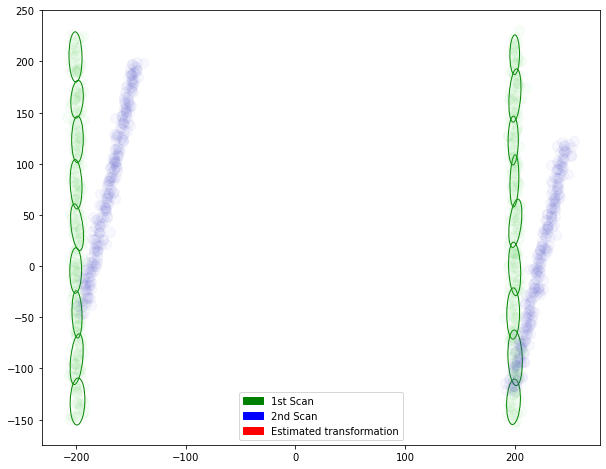

In [898]:
# from NDT import NDT_old as NDT
from NDT import NDT

fig9_2 = plt.figure()
ax9_2 = fig9_2.add_subplot()
# ax9.set_xlim(-125,150)
green = mpatches.Patch(color='green', label='1st Scan')
blue = mpatches.Patch(color='blue', label='2nd Scan')
red = mpatches.Patch(color='red', label='Estimated transformation')
plt.legend(handles=[green, blue, red])

a = 59 #59 #10 #97 #33 #easy test scans
fidelity = 10 # [N x N] grid of ellipses
nc = 250  # number of cycles in each trial
atd = True #along track demo

numTrials = 10
NDT_errors = np.zeros([numTrials,3])
for i in range(numTrials):
    r, t, results, x_actual = NDT(dat1[a],dat2[a],fig9_2,ax9_2, fid = fidelity, 
                                  num_cycles = nc, along_track_demo = atd,
                                 output_actual = True)
    x_est = np.array([t[0], t[1], r]).T
    dif = x_actual + x_est
    print("Epoch ", i)
    print("Estimated transformation \n", x_est)
    print("Actual transformation: \n", x_actual)
    print("difference: \n", dif)
    NDT_errors[i,:] = dif

In [2334]:
print(np.std(NDT_errors, axis = 0))
# print(NDT_errors)
NDT_errors_no_outliars = NDT_errors[abs(NDT_errors[:,2]) < 0.05]
print(np.shape(NDT_errors_no_outliars))
print("no outliars  :  ", np.std(NDT_errors_no_outliars, axis=0))
print("with outliars:  ", np.std(NDT_errors, axis = 0))

NameError: name 'NDT_errors' is not defined

### Questions about NDT

1) NDT: It seems like optimal hyperparameter values are different between scans. Are there rules of thumb that can be used to generalize step size, etc?

2) Only works when we set minimum ellipse size (or else we could be 100 STDs away)

3) Square standard deviations (to discourage outliars)- is this like adding variances???

4) Momentum parameters for gradient descent (similar to adam?)

## Iterative Closest Ellipse Transform (ICET)

V1: ICP applied to ellipses

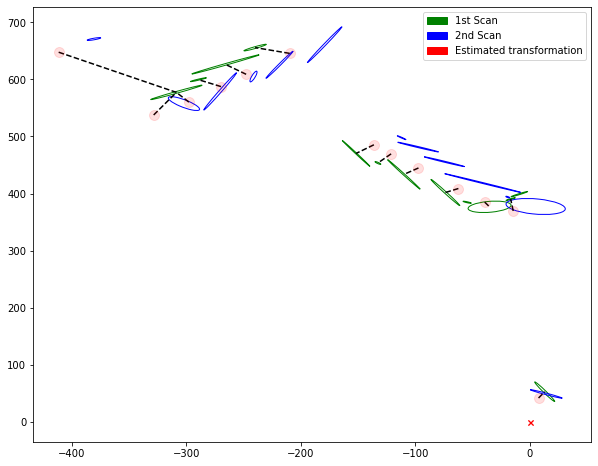

In [13]:
from ICET import ICET_v1

fig11 = plt.figure()
ax11 = fig11.add_subplot()
green = mpatches.Patch(color='green', label='1st Scan')
blue = mpatches.Patch(color='blue', label='2nd Scan')
red = mpatches.Patch(color='red', label='Estimated transformation')
plt.legend(handles=[green, blue, red])

a = int(100*np.random.rand())
a = 40 #59 #10 #97 #33 #easy test scans
fidelity = 10 # [N x N] grid of ellipses
nc = 100       # number of cycles

t, rot = ICET_v1(dat1[a],dat2[a],fig11,ax11, fid = fidelity, num_cycles = nc)

### Questions about ICET

uncharacteristically wide noise distributions are anomalies for lidar point clouds -> wide distributions reflect deterministic structure in the scene

Our technique should exclude the two elongated directons but preserve the direction normal to the wall
    
    Is this just like NDT?
    
(Page 9) How can we replace y with z? if z is missing a dimension how is it useful for calculating averages?

should voxels be rigidly fixed in world space? or should they range between minimum and maximum points?

In [451]:
from ICET import weighted_psudoinverse

H = np.array([[1, 2],[3, 4],[5, 6]])    #jacobian of first scan of points
H1 = np.array([[2, 2],[2, 3],[2, 2.5]]) #jacobian of translated points

print("H: \n", H)

W = np.identity(np.shape(H)[0]) #debug this...
print("W: \n", W)

#solves for x in Ax = b
H_w = weighted_psudoinverse(H, W) 
print("H^w: \n", H_w)


#proof this works
# print("(H^w)*H: \n", np.round(H_w.dot(H), decimals = 10))
#gets the same results as the MatLab function pinv(A) or np.linalg.pinv

#state estimate update on top of page 5 of ICET
print("dx = \n", H_w.dot(H-H1))

H: 
 [[1 2]
 [3 4]
 [5 6]]
W: 
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
H^w: 
 [[-1.33333333 -0.33333333  0.66666667]
 [ 1.08333333  0.33333333 -0.41666667]]
dx = 
 [[ 3.     2.   ]
 [-2.    -1.125]]


In [452]:
from ICET import get_H

x = np.array([[1],[2],[0.1]])
H = get_H(P,x)
print("P: \n", P)

# print(H)
W = np.identity(np.shape(H)[0])
# print("W: \n", W)

H_w = weighted_psudoinverse(H, W) 
# print(H_w)
print("(H^w)*H: \n", np.round(H_w.dot(H), decimals = 10))

P: 
 [[ 4.23595717  4.39641694  5.07910565  4.44839518  4.79607064  5.24616566
   5.46237657  8.16871422  8.81290625 11.34126572 13.24538737 14.09006671
  14.54353957 14.56236087 13.16917507 12.20544931 12.42092548 11.93685694
  11.97888843 14.09287128 18.18080328 19.43211973]
 [ 9.75693049 10.85981844 12.88142347 13.65325807 15.05499666 15.83703467
  15.44767719 16.63936333 15.15444826 15.44659617 15.60666939 15.73125203
  16.79703422 18.73781562 20.19671415 22.34953157 25.1491961  25.99235624
  25.65217087 25.63613359 26.2637068  23.5208752 ]]
(H^w)*H: 
 [[ 0.16596428  0.36209539 -0.08548136]
 [ 0.36209539  0.84279681  0.03711161]
 [-0.08548136  0.03711161  0.99123891]]


## State estimation with ICET

X = X + dx

dx = H_w(y - y0) , y & y0 are point cloud mean vectors | dx shape=[3,1]

y ~= y0 + Hdx + HOT

error: 
 [[-9.04034899e-03  2.42277738e+01 -1.65183382e-04]]
predicted error std: 
 0.10095972622114002 3.404691362504152 0.0012982207459352006
L2: 
 [[1. 0. 0.]
 [0. 1. 0.]]


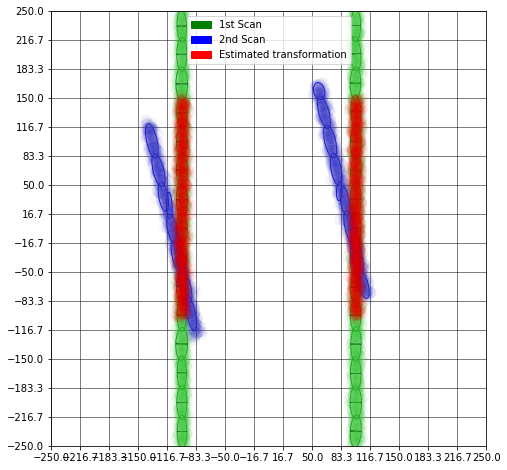

In [2379]:
from ICET import ICET_v2
fig12 = plt.figure()
ax12 = fig12.add_subplot()
ax12.set_aspect('equal') 

# a = int(10*np.random.rand())
# print(a)

# dat = np.load("data/cross_track.npy")
# a = 9             #makes cross track blow up (without new L matrix)
# dat = np.load("data/cross_track_rotated.npy")

# dat = np.load("data/along_track.npy")
# a = 0 #makes along track example explode

dat = np.load("data/high_res_noisy_dxdy_100.npy") #default
a = 59            # easy test scans on default dataset: #40 #59 #10 #97 #33 

# dat = np.load("data/validation.npy")
# a = 2 #good validation example

dat1 = dat[:,:scanpts]
dat2 = dat[:,scanpts:2*scanpts]

green = mpatches.Patch(color='green', label='1st Scan')
blue = mpatches.Patch(color='blue', label='2nd Scan')
red = mpatches.Patch(color='red', label='Estimated transformation')
plt.legend(handles=[green, blue, red])


fidelity = 15     # [N x N] grid of ellipses
nc = 10    # number of cycles
min_num_pts = 30  # minimum number of points per ellipse #works well with 5 for default
atd = True #along track demo

if atd == True:
    X, Q, hist, x_actual, condinfo = ICET_v2(dat1[a],dat2[a],fig12,ax12, 
                                              fid = fidelity, num_cycles = nc, min_num_pts = min_num_pts, along_track_demo = atd)
#     print("x actual: \n", x_actual)
    print("error: \n", x_actual+X.T)
else:
    X, Q, hist, condinfo = ICET_v2(dat1[a],dat2[a],fig12,ax12, 
                                    fid = fidelity, num_cycles = nc, min_num_pts = min_num_pts, along_track_demo = atd)
# print("best transformation X = \n", X.T)
# print("Q = \n", Q)

print("predicted error std: \n", np.sqrt(Q[0,0]), np.sqrt(Q[1,1]), np.sqrt(Q[2,2]))

print("L2: \n", condinfo[0])
# print("lam: \n", condinfo[1])
# print("U2: \n", condinfo[2])

x_hat_hist, y_hist, z_hist = hist
# print(y_hist)


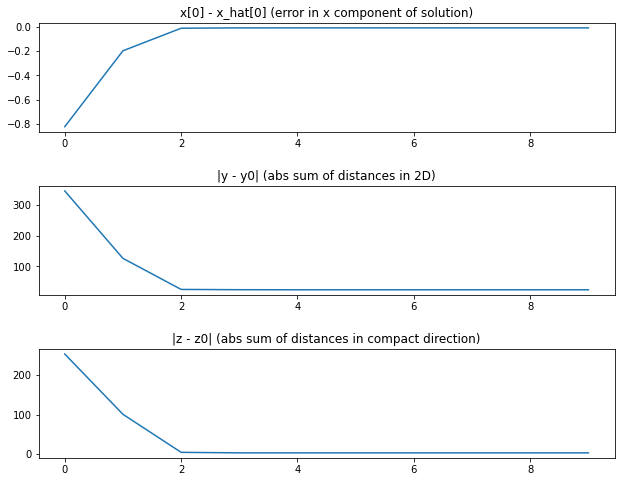

In [2380]:
# fig13 = plt.figure()
# ax13 = fig13.add_subplot()
fig13, ax13 = plt.subplots(nrows = 3, ncols =1)
fig13.subplots_adjust(left = 0.1, right = 0.9, hspace = 0.5, wspace = 0.03)
ax13[0].set_title("x[0] - x_hat[0] (error in x component of solution)")
# ax13[0].set_xlabel("iteration")
# ax13[0].set_ylabel("score")
ax13[0].plot(x_hat_hist[:,0] + x_actual[0])

ax13[1].set_title("|y - y0| (abs sum of distances in 2D)")
ax13[1].plot(y_hist)

ax13[2].set_title("|z - z0| (abs sum of distances in compact direction)")
ax13[2].plot(z_hist)

# print(x_actual)
# print(x_hat_hist)


## ICET Monte-Carlo Sim

Epoch  0
[[1.20703392e-03 3.39916566e-02]
 [3.39916566e-02 2.37379060e+00]]
[[1.78438542e-03 5.02463372e-02]
 [5.02463372e-02 2.83154832e+00]]
[[1.78448084e-03 5.02499536e-02]
 [5.02499536e-02 2.83154678e+00]]
[[1.78430703e-03 5.02434771e-02]
 [5.02434771e-02 2.81070660e+00]]
[[1.75821591e-03 4.95079686e-02]
 [4.95079686e-02 2.81074695e+00]]
[[1.78433234e-03 5.02432287e-02]
 [5.02432287e-02 2.83154213e+00]]
[[1.78427583e-03 5.02430795e-02]
 [5.02430795e-02 2.81071653e+00]]
[[1.44322141e-03 4.06413831e-02]
 [4.06413831e-02 2.56106105e+00]]
[[1.60077134e-03 4.50743425e-02]
 [4.50743425e-02 2.68589847e+00]]
[[1.7582623e-03 4.9510060e-02]
 [4.9510060e-02 2.8107342e+00]]
[[1.78451971e-03 5.02460748e-02]
 [5.02460748e-02 2.81070994e+00]]
[[1.78453703e-03 5.02489390e-02]
 [5.02489390e-02 2.83154707e+00]]
[[1.75816338e-03 4.95059963e-02]
 [4.95059963e-02 2.81074253e+00]]
[[1.78471596e-03 5.02509097e-02]
 [5.02509097e-02 2.81071507e+00]]
[[1.78436412e-03 5.02457853e-02]
 [5.02457853e-02 2.83153

 [5.64230368e-06 2.62500074e+00]]
[[2.99998038e-10 2.22549674e-06]
 [2.22549674e-06 2.83332752e+00]]
[[2.86691134e-10 3.78739010e-06]
 [3.78739010e-06 2.83333097e+00]]
[[ 2.96118110e-10 -4.53412187e-06]
 [-4.53412187e-06  2.79166020e+00]]
[[2.91913325e-10 6.38474762e-07]
 [6.38474762e-07 2.83334182e+00]]
[[ 2.83104756e-10 -2.73183163e-06]
 [-2.73183163e-06  2.83333452e+00]]
[[ 3.02024394e-10 -1.29134742e-06]
 [-1.29134742e-06  2.79166841e+00]]
[[3.55483415e-10 9.10528868e-07]
 [9.10528868e-07 2.33333224e+00]]
[[ 3.35656822e-10 -8.96302920e-07]
 [-8.96302920e-07  2.62499850e+00]]
[[3.51128383e-10 1.48591188e-06]
 [1.48591188e-06 2.83332343e+00]]
[[ 2.88388337e-10 -7.70920498e-07]
 [-7.70920498e-07  2.81249304e+00]]
[[3.51173129e-10 1.00581949e-06]
 [1.00581949e-06 2.81249720e+00]]
[[ 2.89907139e-10 -2.57439736e-06]
 [-2.57439736e-06  2.83333166e+00]]
[[3.33432845e-10 4.76131627e-06]
 [4.76131627e-06 2.81250007e+00]]
[[ 3.56977505e-10 -2.38674711e-07]
 [-2.38674711e-07  2.81249232e+00]]


[[0.38666117 0.55646346]
 [0.55646346 2.2175069 ]]
[[0.55624858 0.80052894]
 [0.80052894 2.56874972]]
[[0.48841271 0.70290357]
 [0.70290357 2.42825983]]
[[0.31882361 0.45884043]
 [0.45884043 2.05617628]]
[[0.2442072  0.35145307]
 [0.35145307 1.90162524]]
[[0.55624949 0.80052851]
 [0.80052851 2.56874758]]
[[0.44771317 0.64432875]
 [0.64432875 2.34395419]]
[[0.4409293  0.6345633 ]
 [0.6345633  2.30906378]]
[[0.35952678 0.51741079]
 [0.51741079 2.16130264]]
[[0.447714   0.6443299 ]
 [0.6443299  2.34395645]]
[[0.55624932 0.80053197]
 [0.80053197 2.54791533]]
[[0.42736108 0.61504033]
 [0.61504033 2.30181163]]
[[0.37987921 0.54670665]
 [0.54670665 2.2034659 ]]
[[0.21028709 0.30263512]
 [0.30263512 1.85220841]]
[[9.08830025e-05 1.13483352e-02]
 [1.13483352e-02 2.83324299e+00]]
[[9.08702981e-05 1.13470711e-02]
 [1.13470711e-02 2.81239532e+00]]
[[8.94939752e-05 1.11755744e-02]
 [1.11755744e-02 2.81241809e+00]]
[[9.08969578e-05 1.13484502e-02]
 [1.13484502e-02 2.83324150e+00]]
[[9.08576325e-05 1

[[2.85095285e-10 2.99609633e-06]
 [2.99609633e-06 2.83333335e+00]]
[[3.36308268e-10 2.18599505e-06]
 [2.18599505e-06 2.81248568e+00]]
[[ 2.49350620e-10 -2.91225571e-06]
 [-2.91225571e-06  2.81250759e+00]]
[[3.43279951e-10 2.95227779e-06]
 [2.95227779e-06 2.83333101e+00]]
[[3.07730972e-10 1.24329323e-06]
 [1.24329323e-06 2.83333921e+00]]
[[3.65864274e-10 3.94794159e-06]
 [3.94794159e-06 2.79166179e+00]]
[[3.46617729e-10 2.24811308e-06]
 [2.24811308e-06 2.83333561e+00]]
[[ 3.12932658e-10 -1.61903798e-06]
 [-1.61903798e-06  2.83333773e+00]]
[[3.44672683e-10 4.11537052e-06]
 [4.11537052e-06 2.81248799e+00]]
[[ 2.45847372e-10 -1.78518403e-07]
 [-1.78518403e-07  2.81250900e+00]]
[[ 2.87643441e-10 -3.49669157e-07]
 [-3.49669157e-07  2.83334159e+00]]
[[ 1.96615884e-10 -3.35642986e-06]
 [-3.35642986e-06  2.83332934e+00]]
[[2.37680848e-10 9.71879741e-07]
 [9.71879741e-07 2.79166194e+00]]
[[3.25059893e-10 1.60173171e-07]
 [1.60173171e-07 2.83332645e+00]]
[[2.85095267e-10 2.99608512e-06]
 [2.99608

 [0.16439749 2.21619762]]
[[0.05830904 0.28358291]
 [0.28358291 2.7750264 ]]
[[0.05915348 0.28769257]
 [0.28769257 2.81583827]]
[[0.05830814 0.28357851]
 [0.28357851 2.77503203]]
[[0.03718278 0.18083632]
 [0.18083632 2.29615677]]
[[0.05830828 0.2835843 ]
 [0.2835843  2.79585536]]
[[0.05830752 0.28357813]
 [0.28357813 2.79586367]]
[[0.04478894 0.21782939]
 [0.21782939 2.47604133]]
[[0.04647823 0.22604569]
 [0.22604569 2.51602074]]
[[0.05830837 0.28358322]
 [0.28358322 2.79586121]]
[[0.0583074  0.28357823]
 [0.28357823 2.77502651]]
[[0.05830798 0.28357843]
 [0.28357843 2.79586279]]
[[0.05830792 0.28358084]
 [0.28358084 2.79585978]]
[[0.05661739 0.27536127]
 [0.27536127 2.73504866]]
[[0.05830844 0.28358296]
 [0.28358296 2.7958624 ]]
[[0.03295632 0.16028758]
 [0.16028758 2.17537731]]
[[0.26303899 0.56558748]
 [0.56558748 2.61196366]]
[[0.27414981 0.5894837 ]
 [0.5894837  2.68417736]]
[[0.22228497 0.47795877]
 [0.47795877 2.42355892]]
[[0.27415392 0.58948689]
 [0.58948689 2.68418765]]
[[0.1

[[ 3.45796909e-10 -1.42736850e-06]
 [-1.42736850e-06  2.81250476e+00]]
[[ 3.68740158e-10 -4.43782041e-06]
 [-4.43782041e-06  2.81250536e+00]]
[[3.28554376e-10 1.20811556e-06]
 [1.20811556e-06 2.83333190e+00]]
[[2.70394592e-10 3.25235990e-06]
 [3.25235990e-06 2.81249992e+00]]
[[3.26969463e-10 5.48714930e-07]
 [5.48714930e-07 2.81250133e+00]]
[[2.73433685e-10 4.74142859e-06]
 [4.74142859e-06 2.81250672e+00]]
[[3.84152239e-10 2.01983647e-06]
 [2.01983647e-06 2.39582567e+00]]
[[3.86829885e-10 2.43417728e-06]
 [2.43417728e-06 2.56249922e+00]]
[[ 2.64486697e-10 -9.17362850e-07]
 [-9.17362850e-07  2.81250105e+00]]
[[2.81901259e-10 1.45718800e-06]
 [1.45718800e-06 2.81249302e+00]]
[[ 2.83471051e-10 -2.97886941e-06]
 [-2.97886941e-06  2.81250120e+00]]
[[ 2.78581706e-10 -7.93230508e-07]
 [-7.93230508e-07  2.83333722e+00]]
[[2.28921480e-10 4.34361946e-06]
 [4.34361946e-06 2.81249538e+00]]
[[ 2.99879341e-10 -3.48526082e-06]
 [-3.48526082e-06  2.83333605e+00]]
[[3.22886467e-10 3.50907045e-06]
 [3.5

Epoch  3
[[0.01572645 0.10278605]
 [0.10278605 2.08844084]]
[[0.03240544 0.2117986 ]
 [0.2117986  2.78009915]]
[[0.03240575 0.21179753]
 [0.21179753 2.80093056]]
[[0.03288268 0.21491137]
 [0.21491137 2.82128699]]
[[0.03240687 0.21179878]
 [0.21179878 2.80092972]]
[[0.03288293 0.21491463]
 [0.21491463 2.8004494 ]]
[[0.03240586 0.21179908]
 [0.21179908 2.80092924]]
[[0.02430417 0.15884625]
 [0.15884625 2.43402005]]
[[0.02668692 0.17442136]
 [0.17442136 2.55664966]]
[[0.03240657 0.21179999]
 [0.21179999 2.78009406]]
[[0.03288274 0.21491275]
 [0.21491275 2.82128711]]
[[0.03240693 0.21179865]
 [0.21179865 2.80092548]]
[[0.03288288 0.21491323]
 [0.21491323 2.82128021]]
[[0.03240576 0.21180002]
 [0.21180002 2.78008917]]
[[0.02192236 0.14327879]
 [0.14327879 2.35309355]]
[[6.77388395e-04 3.09720429e-02]
 [3.09720429e-02 2.83265130e+00]]
[[6.77476102e-04 3.09752708e-02]
 [3.09752708e-02 2.81183643e+00]]
[[6.67446448e-04 3.05159706e-02]
 [3.05159706e-02 2.81183708e+00]]
[[6.77339983e-04 3.096819

 [1.90749054e-06 2.81249200e+00]]
[[3.58201831e-10 5.21039628e-06]
 [5.21039628e-06 2.81251141e+00]]
[[3.44568771e-10 1.47381893e-06]
 [1.47381893e-06 2.83333066e+00]]
[[ 2.74629765e-10 -7.69309681e-07]
 [-7.69309681e-07  2.81250842e+00]]
[[ 2.16932334e-10 -2.86511896e-06]
 [-2.86511896e-06  2.83333157e+00]]
[[3.09128682e-10 1.87458660e-06]
 [1.87458660e-06 2.81248721e+00]]
[[3.09773448e-10 3.35744069e-06]
 [3.35744069e-06 2.81249984e+00]]
[[2.35082294e-10 2.09724176e-06]
 [2.09724176e-06 2.81250640e+00]]
[[2.85184819e-10 3.33502638e-07]
 [3.33502638e-07 2.81249522e+00]]
[[ 2.90567819e-10 -1.46547133e-06]
 [-1.46547133e-06  2.83334001e+00]]
[[ 2.19801165e-10 -3.31326105e-06]
 [-3.31326105e-06  2.81250084e+00]]
[[ 2.88844844e-10 -4.80185840e-07]
 [-4.80185840e-07  2.83333221e+00]]
[[3.89413328e-10 5.98236988e-06]
 [5.98236988e-06 2.81250400e+00]]
[[3.12863791e-10 3.09503725e-06]
 [3.09503725e-06 2.81251241e+00]]
[[3.39043626e-10 1.90749584e-06]
 [1.90749584e-06 2.81249200e+00]]
[[3.5820

 [1.90749665e-06 2.81249200e+00]]
[[3.58201853e-10 5.21040248e-06]
 [5.21040248e-06 2.81251141e+00]]
[[3.44568780e-10 1.47382514e-06]
 [1.47382514e-06 2.83333066e+00]]
[[ 2.74629770e-10 -7.69303565e-07]
 [-7.69303565e-07  2.81250842e+00]]
[[ 2.16932328e-10 -2.86511275e-06]
 [-2.86511275e-06  2.83333157e+00]]
[[3.09128694e-10 1.87459281e-06]
 [1.87459281e-06 2.81248721e+00]]
[[3.09773465e-10 3.35744681e-06]
 [3.35744681e-06 2.81249984e+00]]
[[2.35082307e-10 2.09724788e-06]
 [2.09724788e-06 2.81250640e+00]]
[[2.85184822e-10 3.33508845e-07]
 [3.33508845e-07 2.81249522e+00]]
[[ 2.90567810e-10 -1.46546512e-06]
 [-1.46546512e-06  2.83334001e+00]]
[[ 2.19801154e-10 -3.31325493e-06]
 [-3.31325493e-06  2.81250084e+00]]
[[ 2.88844840e-10 -4.80179632e-07]
 [-4.80179632e-07  2.83333221e+00]]
[[3.89413351e-10 5.98237609e-06]
 [5.98237609e-06 2.81250400e+00]]
[[3.12863811e-10 3.09504337e-06]
 [3.09504337e-06 2.81251241e+00]]
Epoch  4
[[0.15156905 0.37580081]
 [0.37580081 2.32759708]]
[[0.21278056 0.

 [5.02396014e-07 2.83332874e+00]]
[[ 3.26361897e-10 -3.23910710e-06]
 [-3.23910710e-06  2.81249907e+00]]
[[ 3.13881315e-10 -2.92427619e-06]
 [-2.92427619e-06  2.83332941e+00]]
[[ 2.97254552e-10 -7.92016831e-07]
 [-7.92016831e-07  2.81249498e+00]]
[[2.69339649e-10 4.16727624e-07]
 [4.16727624e-07 2.81249732e+00]]
[[ 2.82106266e-10 -3.50518669e-06]
 [-3.50518669e-06  2.79166833e+00]]
[[3.71102825e-10 1.23815483e-06]
 [1.23815483e-06 2.16666948e+00]]
[[2.37904289e-10 6.58021974e-07]
 [6.58021974e-07 2.83333040e+00]]
[[ 2.85035444e-10 -1.07992828e-06]
 [-1.07992828e-06  2.81249672e+00]]
[[ 3.02450537e-10 -4.26548866e-07]
 [-4.26548866e-07  2.81250204e+00]]
[[2.31406856e-10 5.19358640e-07]
 [5.19358640e-07 2.81250448e+00]]
[[2.78462345e-10 6.24700221e-07]
 [6.24700221e-07 2.83333428e+00]]
[[2.73045652e-10 6.98206651e-07]
 [6.98206651e-07 2.81249908e+00]]
[[ 3.85602578e-10 -1.07364406e-06]
 [-1.07364406e-06  2.77082966e+00]]
[[ 3.35218143e-10 -7.01235869e-07]
 [-7.01235869e-07  2.16667034e+0

 [6.98074169e-07 2.81249908e+00]]
[[ 3.85602459e-10 -1.07377456e-06]
 [-1.07377456e-06  2.77082966e+00]]
[[ 3.35218639e-10 -7.01307053e-07]
 [-7.01307053e-07  2.16667034e+00]]
[[3.33321269e-10 1.84281438e-06]
 [1.84281438e-06 2.81250363e+00]]
[[2.74251876e-10 4.99006272e-07]
 [4.99006272e-07 2.83332874e+00]]
[[ 3.26376301e-10 -3.24244700e-06]
 [-3.24244700e-06  2.81249907e+00]]
[[ 3.13888095e-10 -2.92766591e-06]
 [-2.92766591e-06  2.83332941e+00]]
[[ 2.97262816e-10 -7.95406584e-07]
 [-7.95406584e-07  2.81249498e+00]]
[[2.69348344e-10 4.13387739e-07]
 [4.13387739e-07 2.81249732e+00]]
[[ 2.82122512e-10 -3.50847674e-06]
 [-3.50847674e-06  2.79166833e+00]]
[[3.71102829e-10 1.23808364e-06]
 [1.23808364e-06 2.16666948e+00]]
[[2.37904416e-10 6.57887516e-07]
 [6.57887516e-07 2.83333040e+00]]
[[ 2.85035435e-10 -1.08006273e-06]
 [-1.08006273e-06  2.81249672e+00]]
[[ 3.02451499e-10 -4.26681347e-07]
 [-4.26681347e-07  2.81250204e+00]]
[[2.31406871e-10 5.19224181e-07]
 [5.19224181e-07 2.81250448e+0

 [-1.04399717e-06  2.79167223e+00]]
[[2.76102417e-10 2.41471793e-06]
 [2.41471793e-06 2.83333336e+00]]
[[2.75332140e-10 3.48144170e-06]
 [3.48144170e-06 2.83333131e+00]]
[[3.04259886e-10 5.04084950e-07]
 [5.04084950e-07 2.81249445e+00]]
[[3.19005531e-10 1.96624949e-06]
 [1.96624949e-06 2.81249948e+00]]
[[3.63461248e-10 1.40049193e-07]
 [1.40049193e-07 2.83333536e+00]]
[[ 2.76377559e-10 -3.14372009e-06]
 [-3.14372009e-06  2.81249779e+00]]
[[ 3.14275797e-10 -1.89542804e-06]
 [-1.89542804e-06  2.79166856e+00]]
[[3.16669207e-10 1.19827533e-06]
 [1.19827533e-06 2.83332815e+00]]
[[2.83425215e-10 4.34131874e-06]
 [4.34131874e-06 2.83332240e+00]]
[[2.87565657e-10 2.83920215e-06]
 [2.83920215e-06 2.79165359e+00]]
[[ 3.12532574e-10 -3.65524380e-07]
 [-3.65524380e-07  2.83333293e+00]]
[[3.33212483e-10 9.30222912e-07]
 [9.30222912e-07 2.83333902e+00]]
[[ 3.43782608e-10 -1.21273568e-06]
 [-1.21273568e-06  2.81249616e+00]]
[[ 2.74313007e-10 -1.04437394e-06]
 [-1.04437394e-06  2.79167223e+00]]
[[2.76

 [-1.04433924e-06  2.79167223e+00]]
[[2.76102222e-10 2.41437076e-06]
 [2.41437076e-06 2.83333336e+00]]
[[2.75331100e-10 3.48109453e-06]
 [3.48109453e-06 2.83333131e+00]]
[[3.04258053e-10 5.03742877e-07]
 [5.03742877e-07 2.81249445e+00]]
[[3.19005446e-10 1.96590231e-06]
 [1.96590231e-06 2.81249948e+00]]
[[3.63460279e-10 1.39702014e-07]
 [1.39702014e-07 2.83333536e+00]]
[[ 2.76378215e-10 -3.14406217e-06]
 [-3.14406217e-06  2.81249779e+00]]
[[ 3.14276836e-10 -1.89577012e-06]
 [-1.89577012e-06  2.79166856e+00]]
[[3.16668912e-10 1.19792815e-06]
 [1.19792815e-06 2.83332815e+00]]
[[2.83424156e-10 4.34097157e-06]
 [4.34097157e-06 2.83332240e+00]]
[[2.87564491e-10 2.83886008e-06]
 [2.83886008e-06 2.79165359e+00]]
[[ 3.12532278e-10 -3.65871557e-07]
 [-3.65871557e-07  2.83333293e+00]]
[[3.33211991e-10 9.29875733e-07]
 [9.29875733e-07 2.83333902e+00]]
[[ 3.43782935e-10 -1.21307775e-06]
 [-1.21307775e-06  2.81249616e+00]]
[[ 2.74312927e-10 -1.04433924e-06]
 [-1.04433924e-06  2.79167223e+00]]
[[2.76

 [-1.09516552e-06  2.83334702e+00]]
[[ 3.15121845e-10 -4.68018192e-06]
 [-4.68018192e-06  2.79166689e+00]]
[[3.98582416e-10 1.41541195e-07]
 [1.41541195e-07 2.83332809e+00]]
[[ 3.69117249e-10 -8.23778795e-07]
 [-8.23778795e-07  2.83333141e+00]]
[[ 2.91077948e-10 -3.18020343e-06]
 [-3.18020343e-06  2.79165541e+00]]
[[ 3.34758711e-10 -1.63273594e-06]
 [-1.63273594e-06  2.83333534e+00]]
[[ 2.33691208e-10 -1.73173214e-06]
 [-1.73173214e-06  2.83332912e+00]]
[[2.24075916e-10 1.79605151e-06]
 [1.79605151e-06 2.83332740e+00]]
[[ 2.40234726e-10 -5.28893169e-06]
 [-5.28893169e-06  2.81250715e+00]]
[[3.55413584e-10 7.38025262e-07]
 [7.38025262e-07 2.81249544e+00]]
[[2.80330387e-10 1.53940624e-06]
 [1.53940624e-06 2.83333276e+00]]
[[2.00013319e-10 9.45837404e-07]
 [9.45837404e-07 2.81250230e+00]]
[[ 2.73651812e-10 -2.86945040e-06]
 [-2.86945040e-06  2.81249953e+00]]
[[ 2.88853231e-10 -5.48969708e-06]
 [-5.48969708e-06  2.83332880e+00]]
[[ 3.41056664e-10 -1.09418290e-06]
 [-1.09418290e-06  2.83334

[[3.55415122e-10 7.39191695e-07]
 [7.39191695e-07 2.81249544e+00]]
[[2.80331095e-10 1.54057267e-06]
 [1.54057267e-06 2.83333276e+00]]
[[2.00013815e-10 9.46986687e-07]
 [9.46986687e-07 2.81250230e+00]]
[[ 2.73650169e-10 -2.86828397e-06]
 [-2.86828397e-06  2.81249953e+00]]
[[ 2.88848169e-10 -5.48853064e-06]
 [-5.48853064e-06  2.83332880e+00]]
[[ 3.41056795e-10 -1.09399908e-06]
 [-1.09399908e-06  2.83334702e+00]]
[[ 3.15118937e-10 -4.67903264e-06]
 [-4.67903264e-06  2.79166689e+00]]
[[3.98584106e-10 1.42707626e-07]
 [1.42707626e-07 2.83332809e+00]]
[[ 3.69118673e-10 -8.22612361e-07]
 [-8.22612361e-07  2.83333141e+00]]
[[ 2.91075040e-10 -3.17905415e-06]
 [-3.17905415e-06  2.79165541e+00]]
[[ 3.34757728e-10 -1.63156951e-06]
 [-1.63156951e-06  2.83333534e+00]]
[[ 2.33687961e-10 -1.73056570e-06]
 [-1.73056570e-06  2.83332912e+00]]
[[2.24074675e-10 1.79721795e-06]
 [1.79721795e-06 2.83332740e+00]]
[[ 2.40228481e-10 -5.28778241e-06]
 [-5.28778241e-06  2.81250715e+00]]
[[3.55415122e-10 7.3919169

 [2.66239749e-06 2.79166640e+00]]
[[ 2.86072988e-10 -2.50620154e-06]
 [-2.50620154e-06  2.83333506e+00]]
[[3.16985480e-10 3.07714588e-06]
 [3.07714588e-06 2.83332836e+00]]
[[3.49005164e-10 2.86591450e-06]
 [2.86591450e-06 2.79167066e+00]]
[[ 2.48430371e-10 -1.43438738e-06]
 [-1.43438738e-06  2.83333193e+00]]
[[3.21980066e-10 7.11415191e-07]
 [7.11415191e-07 2.33333154e+00]]
[[3.18411175e-10 2.21464456e-07]
 [2.21464456e-07 2.62500399e+00]]
[[3.13843837e-10 1.14763856e-06]
 [1.14763856e-06 2.81249328e+00]]
[[ 3.24222455e-10 -3.55580241e-07]
 [-3.55580241e-07  2.81249660e+00]]
[[ 2.69818686e-10 -3.39558415e-06]
 [-3.39558415e-06  2.83333132e+00]]
[[2.75735716e-10 4.13945673e-06]
 [4.13945673e-06 2.83334204e+00]]
[[ 3.00850400e-10 -1.82952697e-06]
 [-1.82952697e-06  2.79166062e+00]]
[[2.98289622e-10 1.15808028e-06]
 [1.15808028e-06 2.83333386e+00]]
[[ 4.03993304e-10 -8.56632008e-07]
 [-8.56632008e-07  2.31249730e+00]]
[[3.05363422e-10 3.98410980e-06]
 [3.98410980e-06 2.62499986e+00]]
[[3.

[[3.17011148e-10 3.08525326e-06]
 [3.08525326e-06 2.83332836e+00]]
[[3.48999794e-10 2.87390267e-06]
 [2.87390267e-06 2.79167066e+00]]
[[ 2.48397982e-10 -1.42627998e-06]
 [-1.42627998e-06  2.83333193e+00]]
[[3.21998471e-10 7.16661124e-07]
 [7.16661124e-07 2.33333154e+00]]
[[3.18435691e-10 2.28379569e-07]
 [2.28379569e-07 2.62500399e+00]]
[[3.13839828e-10 1.15574592e-06]
 [1.15574592e-06 2.81249328e+00]]
[[ 3.24207434e-10 -3.47592113e-07]
 [-3.47592113e-07  2.81249660e+00]]
[[ 2.69809209e-10 -3.38747679e-06]
 [-3.38747679e-06  2.83333132e+00]]
[[2.75758028e-10 4.14756415e-06]
 [4.14756415e-06 2.83334204e+00]]
[[ 3.00861163e-10 -1.82153883e-06]
 [-1.82153883e-06  2.79166062e+00]]
[[2.98302830e-10 1.16618767e-06]
 [1.16618767e-06 2.83333386e+00]]
[[ 4.03995640e-10 -8.51386061e-07]
 [-8.51386061e-07  2.31249730e+00]]
[[3.05361810e-10 3.98375343e-06]
 [3.98375343e-06 2.62499986e+00]]
[[3.39853983e-10 3.27852592e-07]
 [3.27852592e-07 2.83333044e+00]]
[[2.74450920e-10 2.67038564e-06]
 [2.67038

 [4.61662502e-04 2.37500171e+00]]
[[3.30726458e-07 6.83021143e-04]
 [6.83021143e-04 2.81250111e+00]]
[[3.31291753e-07 6.83144895e-04]
 [6.83144895e-04 2.83332462e+00]]
[[3.25772443e-07 6.70450826e-04]
 [6.70450826e-04 2.81249761e+00]]
[[3.27402591e-07 6.78010180e-04]
 [6.78010180e-04 2.81249570e+00]]
[[3.29206655e-07 6.81439796e-04]
 [6.81439796e-04 2.83333117e+00]]
[[3.22625703e-07 6.70840587e-04]
 [6.70840587e-04 2.81249450e+00]]
[[2.71550899e-07 5.65588826e-04]
 [5.65588826e-04 2.58333325e+00]]
[[ 3.61108000e-10 -2.76809798e-06]
 [-2.76809798e-06  2.37500703e+00]]
[[ 2.91877733e-10 -5.36352941e-07]
 [-5.36352941e-07  2.81249433e+00]]
[[ 2.80083373e-10 -3.12433435e-06]
 [-3.12433435e-06  2.81250267e+00]]
[[ 3.57415709e-10 -8.41370567e-07]
 [-8.41370567e-07  2.83333638e+00]]
[[ 3.48150046e-10 -7.58367530e-06]
 [-7.58367530e-06  2.83333517e+00]]
[[ 3.21671242e-10 -4.04801414e-06]
 [-4.04801414e-06  2.79167227e+00]]
[[ 3.33582120e-10 -2.06697646e-06]
 [-2.06697646e-06  2.83333180e+00]]


 [-4.68924749e-06  2.83333517e+00]]
[[ 3.10488418e-10 -1.19615435e-06]
 [-1.19615435e-06  2.79167227e+00]]
[[3.24008679e-10 8.27449918e-07]
 [8.27449918e-07 2.83333180e+00]]
[[3.60548918e-10 2.44362517e-06]
 [2.44362517e-06 2.58333590e+00]]
[[4.40741720e-10 5.44346171e-08]
 [5.44346171e-08 2.37500193e+00]]
[[3.32467430e-10 6.44078940e-07]
 [6.44078940e-07 2.81250144e+00]]
[[2.48368932e-10 9.50513900e-07]
 [9.50513900e-07 2.81249219e+00]]
[[ 2.39106500e-10 -1.77193873e-06]
 [-1.77193873e-06  2.83333190e+00]]
[[ 2.82099953e-10 -4.36345477e-06]
 [-4.36345477e-06  2.81249603e+00]]
[[ 3.60028456e-10 -2.55628935e-07]
 [-2.55628935e-07  2.81249590e+00]]
[[ 2.94159129e-10 -7.75728080e-07]
 [-7.75728080e-07  2.83332619e+00]]
[[3.51013019e-10 3.63290371e-06]
 [3.63290371e-06 2.58333352e+00]]
[[ 3.57232280e-10 -8.10095578e-07]
 [-8.10095578e-07  2.37500703e+00]]
[[2.98310586e-10 2.35806485e-06]
 [2.35806485e-06 2.81249433e+00]]
[[ 2.69678891e-10 -2.72468111e-07]
 [-2.72468111e-07  2.81250267e+00]

[[ 0.00680479 -0.09794828]
 [-0.09794828  2.80569857]]
[[ 0.00680481 -0.09794631]
 [-0.09794631  2.82653553]]
[[ 0.00680463 -0.09794874]
 [-0.09794874  2.82653067]]
[[ 0.0068052  -0.09795344]
 [-0.09795344  2.80569468]]
[[ 0.00670509 -0.09650992]
 [-0.09650992  2.80580387]]
[[ 0.00680462 -0.09794989]
 [-0.09794989  2.82652799]]
[[ 0.00530328 -0.07633859]
 [-0.07633859  2.49469327]]
[[ 0.00670455 -0.09650719]
 [-0.09650719  2.80579679]]
[[ 0.00680494 -0.09794898]
 [-0.09794898  2.82652873]]
[[ 0.00680463 -0.09794057]
 [-0.09794057  2.80569773]]
[[ 0.00680473 -0.09795021]
 [-0.09795021  2.82653755]]
[[ 0.00680541 -0.09795173]
 [-0.09795173  2.82652657]]
[[ 0.00680443 -0.09794337]
 [-0.09794337  2.80568812]]
[[ 0.00480353 -0.06914093]
 [-0.06914093  2.41186188]]
[[ 3.07247494e-04 -2.08592613e-02]
 [-2.08592613e-02  2.83302547e+00]]
[[ 3.07248589e-04 -2.08610852e-02]
 [-2.08610852e-02  2.81219914e+00]]
[[ 3.02750128e-04 -2.05527584e-02]
 [-2.05527584e-02  2.81220148e+00]]
[[ 3.07271566e-04

 [2.01581643e-06 2.83333371e+00]]
[[2.93108428e-10 2.82690238e-07]
 [2.82690238e-07 2.79167337e+00]]
[[2.81224632e-10 2.78671061e-06]
 [2.78671061e-06 2.83333713e+00]]
[[ 3.15123188e-10 -1.11538866e-06]
 [-1.11538866e-06  2.83333184e+00]]
[[ 3.90960785e-10 -6.08339593e-06]
 [-6.08339593e-06  2.79166530e+00]]
[[ 3.02926145e-10 -8.04744353e-07]
 [-8.04744353e-07  2.83333922e+00]]
[[ 2.54310151e-10 -2.07715000e-06]
 [-2.07715000e-06  2.83332979e+00]]
[[3.12482643e-10 2.93278270e-07]
 [2.93278270e-07 2.81249550e+00]]
[[ 2.79071894e-10 -4.85162293e-07]
 [-4.85162293e-07  2.81249707e+00]]
[[ 2.90357339e-10 -4.22732350e-07]
 [-4.22732350e-07  2.83333322e+00]]
[[3.15398729e-10 6.16632413e-06]
 [6.16632413e-06 2.81249991e+00]]
[[2.68759440e-10 2.71005858e-06]
 [2.71005858e-06 2.81250312e+00]]
[[ 2.63138480e-10 -1.88839561e-06]
 [-1.88839561e-06  2.83333716e+00]]
[[2.92977279e-10 4.91322324e-06]
 [4.91322324e-06 2.81249265e+00]]
[[2.62818248e-10 2.01581643e-06]
 [2.01581643e-06 2.83333371e+00]]


[[ 0.27328211 -0.59356377]
 [-0.59356377  2.70588524]]
[[ 0.26963657 -0.58565342]
 [-0.58565342  2.66787095]]
[[4.56781016e-04 2.04551375e-02]
 [2.04551375e-02 2.31205667e+00]]
[[7.05610176e-04 3.16085308e-02]
 [3.16085308e-02 2.83262986e+00]]
[[6.95243025e-04 3.11473141e-02]
 [3.11473141e-02 2.79096866e+00]]
[[7.05773969e-04 3.16138934e-02]
 [3.16138934e-02 2.83262516e+00]]
[[7.05672360e-04 3.16118043e-02]
 [3.16118043e-02 2.83262584e+00]]
[[7.05837862e-04 3.16183689e-02]
 [3.16183689e-02 2.81180180e+00]]
[[6.95381301e-04 3.11450490e-02]
 [3.11450490e-02 2.81180232e+00]]
[[3.53074438e-04 1.58102902e-02]
 [1.58102902e-02 2.12465235e+00]]
[[5.50045852e-04 2.46378475e-02]
 [2.46378475e-02 2.49944789e+00]]
[[7.05828510e-04 3.16105532e-02]
 [3.16105532e-02 2.83262232e+00]]
[[6.95283110e-04 3.11462108e-02]
 [3.11462108e-02 2.81180410e+00]]
[[7.05699454e-04 3.16077430e-02]
 [3.16077430e-02 2.81179622e+00]]
[[7.05724280e-04 3.16084938e-02]
 [3.16084938e-02 2.83263292e+00]]
[[6.95296672e-04 3.

 [-2.03929658e-07  2.41667389e+00]]
[[ 3.12865325e-10 -2.09080029e-06]
 [-2.09080029e-06  2.81249825e+00]]
[[2.51997248e-10 1.35974293e-06]
 [1.35974293e-06 2.81249649e+00]]
[[2.70091794e-10 1.88722565e-06]
 [1.88722565e-06 2.83333259e+00]]
[[ 2.51791792e-10 -5.23204077e-07]
 [-5.23204077e-07  2.81249776e+00]]
[[3.22055603e-10 6.37566416e-06]
 [6.37566416e-06 2.81250720e+00]]
[[ 2.48829664e-10 -1.77721089e-06]
 [-1.77721089e-06  2.83333276e+00]]
[[3.30962621e-10 2.13884704e-06]
 [2.13884704e-06 2.52083120e+00]]
[[ 3.38887094e-10 -7.31606640e-07]
 [-7.31606640e-07  2.41666741e+00]]
[[ 2.74427809e-10 -1.96964884e-06]
 [-1.96964884e-06  2.81249815e+00]]
[[ 2.74403781e-10 -2.01964771e-07]
 [-2.01964771e-07  2.83333410e+00]]
[[ 2.89276247e-10 -2.58330182e-06]
 [-2.58330182e-06  2.81250282e+00]]
[[ 3.74339207e-10 -1.50913903e-06]
 [-1.50913903e-06  2.81250397e+00]]
[[ 2.04154383e-10 -4.52150528e-06]
 [-4.52150528e-06  2.83333243e+00]]
[[ 2.51135177e-10 -2.09035861e-07]
 [-2.09035861e-07  2.8

 [-0.19774416  2.4193399 ]]
[[ 0.05381545 -0.27288041]
 [-0.27288041  2.80035673]]
[[ 0.05381662 -0.27288148]
 [-0.27288148  2.80035059]]
[[ 0.05381741 -0.27288298]
 [-0.27288298  2.77951735]]
[[ 0.03041748 -0.15423725]
 [-0.15423725  2.19874903]]
[[ 0.0428976  -0.21751536]
 [-0.21751536  2.51960894]]
[[ 0.05381558 -0.27288228]
 [-0.27288228  2.80035405]]
[[ 0.05381543 -0.27288136]
 [-0.27288136  2.77951682]]
[[ 0.05381632 -0.27288446]
 [-0.27288446  2.80035456]]
[[ 0.05381648 -0.27288156]
 [-0.27288156  2.80034409]]
[[ 0.05381601 -0.27288333]
 [-0.27288333  2.77951512]]
[[ 0.05381587 -0.27287961]
 [-0.27287961  2.80034542]]
[[ 0.03899672 -0.19773844]
 [-0.19773844  2.41933069]]
[[ 0.03431745 -0.17401403]
 [-0.17401403  2.29902324]]
[[ 0.05381625 -0.27288379]
 [-0.27288379  2.80035205]]
[[ 0.04679728 -0.23728945]
 [-0.23728945  2.59903593]]
[[ 0.00309727 -0.06616938]
 [-0.06616938  2.83023182]]
[[ 0.0030974  -0.06616987]
 [-0.06616987  2.80938976]]
[[ 0.00309762 -0.06617352]
 [-0.06617

[[ 3.69887985e-10 -1.07919394e-06]
 [-1.07919394e-06  2.81248848e+00]]
[[ 2.49482351e-10 -2.74022542e-06]
 [-2.74022542e-06  2.81250551e+00]]
[[ 2.84803124e-10 -2.36485034e-07]
 [-2.36485034e-07  2.83333712e+00]]
[[2.83982550e-10 4.55710056e-06]
 [4.55710056e-06 2.83333582e+00]]
[[3.57889083e-10 4.91601936e-06]
 [4.91601936e-06 2.79166710e+00]]
[[ 3.03409538e-10 -1.13173862e-06]
 [-1.13173862e-06  2.83332987e+00]]
[[ 2.24924883e-10 -4.99663543e-06]
 [-4.99663543e-06  2.83333893e+00]]
[[ 3.57601313e-10 -2.99965858e-07]
 [-2.99965858e-07  2.83333859e+00]]
[[2.51818154e-10 3.64617719e-06]
 [3.64617719e-06 2.79167333e+00]]
[[ 3.31011098e-10 -3.78868822e-06]
 [-3.78868822e-06  2.83334204e+00]]
[[3.10606014e-10 1.39249056e-06]
 [1.39249056e-06 2.83332162e+00]]
[[ 3.62214119e-10 -3.41771302e-06]
 [-3.41771302e-06  2.79166688e+00]]
[[3.07389217e-10 2.65289047e-06]
 [2.65289047e-06 2.83333495e+00]]
[[ 3.26557506e-10 -4.26028356e-06]
 [-4.26028356e-06  2.83333202e+00]]
[[ 3.69887985e-10 -1.07919

 [0.17934731 2.09867285]]
[[0.09432553 0.35869216]
 [0.35869216 2.7598478 ]]
[[0.05389899 0.20496586]
 [0.20496586 2.1961032 ]]
[[0.041773   0.15885073]
 [0.15885073 2.0207273 ]]
[[0.09432439 0.35869474]
 [0.35869474 2.78067483]]
[[0.0943246  0.35868914]
 [0.35868914 2.78067554]]
[[0.09432378 0.35868985]
 [0.35868985 2.75983981]]
[[0.06063674 0.23058521]
 [0.23058521 2.29353146]]
[[0.07141768 0.27158147]
 [0.27158147 2.44941316]]
[[0.09432334 0.35868765]
 [0.35868765 2.78067281]]
[[0.09432537 0.35868998]
 [0.35868998 2.78067313]]
[[0.07411265 0.28182703]
 [0.28182703 2.48838253]]
[[0.09297784 0.35356928]
 [0.35356928 2.74035589]]
[[0.09432553 0.35869217]
 [0.35869217 2.78067515]]
[[0.0943242  0.35869186]
 [0.35869186 2.7598413 ]]
[[0.05659429 0.21521193]
 [0.21521193 2.2350669 ]]
[[1.20133702e-03 4.12367654e-02]
 [4.12367654e-02 2.83213246e+00]]
[[1.20115647e-03 4.12316387e-02]
 [4.12316387e-02 2.81129964e+00]]
[[1.18353554e-03 4.06287851e-02]
 [4.06287851e-02 2.81132510e+00]]
[[1.2014

 [2.47021357e-06 2.81249993e+00]]
[[ 3.97202471e-10 -3.44807073e-06]
 [-3.44807073e-06  2.81249493e+00]]
[[ 3.17920789e-10 -7.32656159e-07]
 [-7.32656159e-07  2.83333699e+00]]
[[2.58257259e-10 5.79474020e-06]
 [5.79474020e-06 2.81249727e+00]]
[[ 3.57976926e-10 -3.78645234e-06]
 [-3.78645234e-06  2.83333482e+00]]
[[ 3.13869243e-10 -4.68777158e-07]
 [-4.68777158e-07  2.81249048e+00]]
[[ 2.91877804e-10 -2.27536836e-06]
 [-2.27536836e-06  2.81251348e+00]]
[[ 3.85208224e-10 -2.99252667e-06]
 [-2.99252667e-06  2.81249858e+00]]
[[ 2.06910528e-10 -2.39235005e-07]
 [-2.39235005e-07  2.83333373e+00]]
[[ 2.24063685e-10 -2.02084433e-07]
 [-2.02084433e-07  2.81249092e+00]]
[[ 3.34315593e-10 -4.07805966e-06]
 [-4.07805966e-06  2.81250769e+00]]
[[3.31564999e-10 1.69168040e-06]
 [1.69168040e-06 2.81249917e+00]]
[[2.24177374e-10 4.43278434e-07]
 [4.43278434e-07 2.83333543e+00]]
[[2.92890042e-10 8.44219383e-07]
 [8.44219383e-07 2.81250171e+00]]
[[2.06340284e-10 2.47021357e-06]
 [2.47021357e-06 2.8124999

 [-0.06832327  2.83002744]]
[[ 0.00330341 -0.06832783]
 [-0.06832783  2.83003065]]
[[ 0.00310904 -0.06430986]
 [-0.06430986  2.72605583]]
[[ 1.79744496e-03 -3.71787968e-02]
 [-3.71787968e-02  2.16486998e+00]]
[[ 0.00330347 -0.06832865]
 [-0.06832865  2.83002997]]
[[ 0.00330346 -0.06833017]
 [-0.06833017  2.83004119]]
[[ 0.00330312 -0.06832701]
 [-0.06832701  2.80918374]]
[[ 0.00291468 -0.06028864]
 [-0.06028864  2.66375681]]
[[ 0.00320588 -0.06631662]
 [-0.06631662  2.78846144]]
[[ 0.00330331 -0.06832603]
 [-0.06832603  2.83002006]]
[[ 0.00325478 -0.06732675]
 [-0.06732675  2.7884186 ]]
[[ 0.00330326 -0.06832863]
 [-0.06832863  2.83003318]]
[[ 0.00330305 -0.06832562]
 [-0.06832562  2.83004175]]
[[ 0.00325478 -0.06732242]
 [-0.06732242  2.80925188]]
[[ 0.00330329 -0.06832883]
 [-0.06832883  2.80920144]]
[[0.00496229 0.08369901]
 [0.08369901 2.82837048]]
[[0.00496254 0.08369953]
 [0.08369953 2.82837852]]
[[0.00496259 0.08369941]
 [0.08369941 2.80753   ]]
[[0.00488936 0.08246863]
 [0.0824

 [-2.16064077e-06  2.83333537e+00]]
[[ 3.29880861e-10 -2.15948109e-06]
 [-2.15948109e-06  2.81250885e+00]]
[[3.97128106e-10 2.37365049e-06]
 [2.37365049e-06 2.81248915e+00]]
[[2.80009505e-10 2.21230009e-06]
 [2.21230009e-06 2.83334072e+00]]
[[2.86632285e-10 3.54665737e-06]
 [3.54665737e-06 2.81249602e+00]]
[[3.07725374e-10 1.10541825e-06]
 [1.10541825e-06 2.83333209e+00]]
[[2.94641444e-10 2.92712045e-07]
 [2.92712045e-07 2.81249367e+00]]
[[ 2.93349377e-10 -2.66687312e-06]
 [-2.66687312e-06  2.83333650e+00]]
[[3.60282611e-10 1.09451665e-06]
 [1.09451665e-06 2.81250617e+00]]
[[ 3.03785716e-10 -1.17108414e-06]
 [-1.17108414e-06  2.83333006e+00]]
[[ 2.72722702e-10 -2.98998112e-07]
 [-2.98998112e-07  2.81249503e+00]]
[[3.25487923e-10 2.74412703e-06]
 [2.74412703e-06 2.81250605e+00]]
[[3.22187865e-10 2.69663837e-06]
 [2.69663837e-06 2.83333062e+00]]
[[ 3.25017744e-10 -4.18874619e-06]
 [-4.18874619e-06  2.81250259e+00]]
[[ 3.39195253e-10 -2.16064077e-06]
 [-2.16064077e-06  2.83333537e+00]]
[[

 [0.11247211 2.27695107]]
[[0.02380773 0.18209675]
 [0.18209675 2.80952795]]
[[0.02380755 0.1820998 ]
 [0.1820998  2.80952391]]
[[0.02415799 0.18478123]
 [0.18478123 2.80918053]]
[[0.02380812 0.18210042]
 [0.18210042 2.80951946]]
[[0.02380809 0.18210199]
 [0.18210199 2.80952644]]
[[0.0115527  0.08836784]
 [0.08836784 2.07176805]]
[[0.01260333 0.09640324]
 [0.09640324 2.13322372]]
[[0.01995646 0.15264781]
 [0.15264781 2.58421719]]
[[0.02380751 0.18210089]
 [0.18210089 2.8095288 ]]
[[0.02380776 0.18210006]
 [0.18210006 2.8095282 ]]
[[0.02415784 0.18477857]
 [0.18477857 2.82999933]]
[[0.02380808 0.18210067]
 [0.18210067 2.78868352]]
[[0.02380624 0.18209535]
 [0.18209535 2.80951311]]
[[0.02380677 0.18209284]
 [0.18209284 2.78868899]]
[[0.02170671 0.16603121]
 [0.16603121 2.68662389]]
[[ 5.73961901e-05 -9.01804973e-03]
 [-9.01804973e-03  2.83327757e+00]]
[[ 5.73661661e-05 -9.01891414e-03]
 [-9.01891414e-03  2.83328542e+00]]
[[ 5.65248160e-05 -8.88270230e-03]
 [-8.88270230e-03  2.81245123e+0

 [-3.14891504e-06  2.81250128e+00]]
[[ 3.55970933e-10 -3.63907621e-06]
 [-3.63907621e-06  2.83334303e+00]]
[[ 2.61106216e-10 -5.85353680e-07]
 [-5.85353680e-07  2.83334055e+00]]
[[2.87882484e-10 1.27430554e-07]
 [1.27430554e-07 2.79167716e+00]]
[[ 3.31274421e-10 -1.40759778e-06]
 [-1.40759778e-06  2.83333757e+00]]
[[ 2.62724648e-10 -1.88303514e-06]
 [-1.88303514e-06  2.83333054e+00]]
[[2.25783404e-10 1.18917313e-06]
 [1.18917313e-06 2.79166293e+00]]
[[2.45076757e-10 2.83465089e-07]
 [2.83465089e-07 2.81249816e+00]]
[[ 3.19396120e-10 -1.75370653e-06]
 [-1.75370653e-06  2.83332751e+00]]
[[ 3.27069216e-10 -8.10544555e-07]
 [-8.10544555e-07  2.83332896e+00]]
[[3.76507102e-10 1.03637259e-06]
 [1.03637259e-06 2.79166511e+00]]
[[ 3.41038756e-10 -9.68616340e-07]
 [-9.68616340e-07  2.83332997e+00]]
[[ 2.82454887e-10 -3.61299611e-06]
 [-3.61299611e-06  2.81250102e+00]]
[[2.99738027e-10 6.66755408e-07]
 [6.66755408e-07 2.81250618e+00]]
[[ 3.08796713e-10 -3.14891504e-06]
 [-3.14891504e-06  2.81250

 [-0.07551638  2.34817802]]
[[ 0.00885108 -0.11162993]
 [-0.11162993  2.82448669]]
[[ 0.00885096 -0.11162717]
 [-0.11162717  2.80364581]]
[[ 0.00885125 -0.11162741]
 [-0.11162741  2.82448433]]
[[ 0.00885139 -0.11162901]
 [-0.11162901  2.82447544]]
[[ 0.00885154 -0.11163162]
 [-0.11163162  2.82448562]]
[[ 0.00885113 -0.1116276 ]
 [-0.1116276   2.80365213]]
[[ 0.00689887 -0.08700508]
 [-0.08700508  2.51394126]]
[[ 0.00872073 -0.10998429]
 [-0.10998429  2.80378335]]
[[ 0.00885114 -0.11162714]
 [-0.11162714  2.82447879]]
[[ 0.00885128 -0.1116271 ]
 [-0.1116271   2.80364698]]
[[ 0.00885158 -0.1116271 ]
 [-0.1116271   2.82448327]]
[[ 0.00885128 -0.11162712]
 [-0.11162712  2.8244804 ]]
[[ 0.00885151 -0.11162988]
 [-0.11162988  2.8036542 ]]
[[ 0.00885162 -0.11163212]
 [-0.11163212  2.8244764 ]]
[[0.02047433 0.16907128]
 [0.16907128 2.81285425]]
[[0.02047433 0.1690741 ]
 [0.1690741  2.79203184]]
[[0.02047427 0.16907483]
 [0.16907483 2.81285695]]
[[0.02047395 0.16907316]
 [0.16907316 2.81285355]

 [-2.02442347e-06  2.12500091e+00]]
[[ 2.57030378e-10 -2.52673215e-06]
 [-2.52673215e-06  2.81250227e+00]]
[[ 2.67820057e-10 -2.82856275e-06]
 [-2.82856275e-06  2.81250054e+00]]
[[ 3.12814821e-10 -1.04143455e-06]
 [-1.04143455e-06  2.83333219e+00]]
[[ 2.63628915e-10 -7.79005816e-07]
 [-7.79005816e-07  2.81249169e+00]]
[[ 3.26652190e-10 -1.36486828e-06]
 [-1.36486828e-06  2.83333943e+00]]
[[3.12860527e-10 1.51008659e-06]
 [1.51008659e-06 2.81250207e+00]]
[[ 2.99509733e-10 -9.35887140e-07]
 [-9.35887140e-07  2.81250279e+00]]
[[ 4.98110338e-10 -4.16141077e-06]
 [-4.16141077e-06  2.14582205e+00]]
[[3.07829432e-10 7.86508228e-07]
 [7.86508228e-07 2.81250053e+00]]
[[3.11313087e-10 9.97227447e-07]
 [9.97227447e-07 2.83332596e+00]]
[[2.83810308e-10 3.59647669e-06]
 [3.59647669e-06 2.81250154e+00]]
[[2.61731450e-10 2.91595769e-06]
 [2.91595769e-06 2.81251082e+00]]
[[3.46585347e-10 3.46836948e-06]
 [3.46836948e-06 2.83333296e+00]]
[[ 2.43799874e-10 -2.96248204e-06]
 [-2.96248204e-06  2.81250653e

[[5.22586577e-04 2.57664568e-02]
 [2.57664568e-02 2.66614759e+00]]
[[5.73970468e-04 2.82975695e-02]
 [2.82975695e-02 2.81192205e+00]]
[[5.82519057e-04 2.87207986e-02]
 [2.87207986e-02 2.81191338e+00]]
[[5.82594297e-04 2.87195250e-02]
 [2.87195250e-02 2.83275438e+00]]
[[5.73941652e-04 2.82966688e-02]
 [2.82966688e-02 2.81192795e+00]]
[[5.82440820e-04 2.87194481e-02]
 [2.87194481e-02 2.81191944e+00]]
[[5.82604330e-04 2.87203158e-02]
 [2.87203158e-02 2.83274792e+00]]
[[3.51252025e-04 1.73176976e-02]
 [1.73176976e-02 2.27047426e+00]]
[[5.82426485e-04 2.87168490e-02]
 [2.87168490e-02 2.81191120e+00]]
[[5.82483175e-04 2.87206392e-02]
 [2.87206392e-02 2.83275384e+00]]
[[5.73924779e-04 2.82965042e-02]
 [2.82965042e-02 2.79109536e+00]]
[[5.82513333e-04 2.87215073e-02]
 [2.87215073e-02 2.83275053e+00]]
[[5.82554547e-04 2.87218228e-02]
 [2.87218228e-02 2.83274658e+00]]
[[5.73850082e-04 2.82988685e-02]
 [2.82988685e-02 2.81192309e+00]]
[[5.82476788e-04 2.87173538e-02]
 [2.87173538e-02 2.81191263e+

[[2.32246519e-10 9.78569478e-07]
 [9.78569478e-07 2.79166352e+00]]
[[ 3.15716263e-10 -8.22070268e-07]
 [-8.22070268e-07  2.83333457e+00]]
[[ 2.96063643e-10 -3.26326765e-07]
 [-3.26326765e-07  2.83333055e+00]]
[[ 2.60160425e-10 -6.52384732e-08]
 [-6.52384732e-08  2.79166651e+00]]
[[2.40774824e-10 2.62446641e-07]
 [2.62446641e-07 2.83333003e+00]]
[[4.50994165e-10 1.48518112e-06]
 [1.48518112e-06 2.16665669e+00]]
[[ 3.41411383e-10 -3.20948168e-06]
 [-3.20948168e-06  2.77082687e+00]]
[[3.18586697e-10 1.56840105e-06]
 [1.56840105e-06 2.83333440e+00]]
[[3.28966966e-10 3.67699913e-07]
 [3.67699913e-07 2.79167006e+00]]
[[2.85724359e-10 2.33463791e-06]
 [2.33463791e-06 2.83333389e+00]]
[[2.99463334e-10 2.32961264e-06]
 [2.32961264e-06 2.83333021e+00]]
[[3.47966961e-10 2.88929466e-06]
 [2.88929466e-06 2.81249914e+00]]
[[ 2.95738533e-10 -1.00602112e-06]
 [-1.00602112e-06  2.81249541e+00]]
[[ 3.40664407e-10 -6.82641302e-07]
 [-6.82641302e-07  2.16666265e+00]]
[[3.40842508e-10 2.74317636e-06]
 [2.7

 [-0.05504557  2.22552276]]
[[ 0.00620948 -0.09358542]
 [-0.09358542  2.82712314]]
[[ 0.00620893 -0.09357967]
 [-0.09357967  2.82712746]]
[[ 0.00620887 -0.09358155]
 [-0.09358155  2.80629395]]
[[ 0.00611796 -0.09221133]
 [-0.09221133  2.80637969]]
[[ 0.00620942 -0.09358898]
 [-0.09358898  2.80629202]]
[[ 0.00620873 -0.09358251]
 [-0.09358251  2.82712506]]
[[ 0.00556955 -0.08394422]
 [-0.08394422  2.68192455]]
[[ 0.00611789 -0.09220688]
 [-0.09220688  2.80637651]]
[[ 0.00620939 -0.09358703]
 [-0.09358703  2.80630461]]
[[ 0.0062091  -0.09358184]
 [-0.09358184  2.82712508]]
[[ 0.00620941 -0.09358732]
 [-0.09358732  2.82712957]]
[[ 0.00620913 -0.09358357]
 [-0.09358357  2.82711413]]
[[ 0.00620883 -0.09357829]
 [-0.09357829  2.80629332]]
[[ 0.00611816 -0.09221161]
 [-0.09221161  2.80638462]]
[[ 0.01799797 -0.11313792]
 [-0.11313792  2.12782893]]
[[ 0.0179964  -0.11312872]
 [-0.11312872  2.12783599]]
[[ 0.02776509 -0.17454137]
 [-0.17454137  2.49307288]]
[[ 0.03547902 -0.22302995]
 [-0.22302

 [-3.62158077e-07  2.83333034e+00]]
[[2.20270388e-10 3.99034632e-06]
 [3.99034632e-06 2.83333841e+00]]
[[ 2.75590460e-10 -2.41109733e-07]
 [-2.41109733e-07  2.79166856e+00]]
[[ 3.28212629e-10 -7.49661151e-06]
 [-7.49661151e-06  2.83332916e+00]]
[[ 4.10257811e-10 -6.73116466e-06]
 [-6.73116466e-06  2.81249911e+00]]
[[ 3.13145780e-10 -2.85115337e-06]
 [-2.85115337e-06  2.81248913e+00]]
[[3.03740950e-10 3.07822216e-06]
 [3.07822216e-06 2.83332794e+00]]
[[ 2.70015656e-10 -1.19247123e-07]
 [-1.19247123e-07  2.83332937e+00]]
[[ 3.22451635e-10 -4.85861620e-06]
 [-4.85861620e-06  2.81251563e+00]]
[[ 3.10274210e-10 -3.38034087e-09]
 [-3.38034087e-09  2.81249900e+00]]
[[ 3.24432442e-10 -7.01159369e-06]
 [-7.01159369e-06  2.83334337e+00]]
[[ 2.69746462e-10 -3.83735472e-06]
 [-3.83735472e-06  2.83332750e+00]]
[[3.51271547e-10 3.31009141e-06]
 [3.31009141e-06 2.79166962e+00]]
[[ 2.41179596e-10 -5.57817704e-06]
 [-5.57817704e-06  2.83333502e+00]]
[[ 2.81792029e-10 -3.62158077e-07]
 [-3.62158077e-07 

 [-0.37010301  2.77409157]]
[[ 0.10091056 -0.37010502]
 [-0.37010502  2.77408488]]
[[ 0.10090995 -0.37010474]
 [-0.37010474  2.77409187]]
[[ 0.06054558 -0.22206017]
 [-0.22206017  2.21029358]]
[[ 0.10091064 -0.37010532]
 [-0.37010532  2.75325511]]
[[ 0.10091043 -0.37010802]
 [-0.37010802  2.7740979 ]]
[[ 0.09370101 -0.343668  ]
 [-0.343668    2.65630307]]
[[ 0.06342989 -0.23263852]
 [-0.23263852  2.26990306]]
[[ 0.05910414 -0.21677613]
 [-0.21677613  2.21173141]]
[[ 0.10090904 -0.3700985 ]
 [-0.3700985   2.77409133]]
[[ 0.10090995 -0.37010617]
 [-0.37010617  2.7532629 ]]
[[ 0.10235164 -0.37539188]
 [-0.37539188  2.79347674]]
[[ 0.06631332 -0.24321593]
 [-0.24321593  2.30868606]]
[[ 0.10090997 -0.3701067 ]
 [-0.3701067   2.75325615]]
[[ 0.07352035 -0.26965061]
 [-0.26965061  2.40564585]]
[[ 0.00356941 -0.06267666]
 [-0.06267666  2.49642956]]
[[ 0.00457975 -0.08041918]
 [-0.08041918  2.82874994]]
[[ 0.00457977 -0.08041916]
 [-0.08041916  2.80792876]]
[[ 0.00457991 -0.08041753]
 [-0.08041

 [7.40716326e-07 2.83332602e+00]]
[[3.31634962e-10 1.59648478e-06]
 [1.59648478e-06 2.64583251e+00]]
[[3.38203812e-10 1.36282665e-06]
 [1.36282665e-06 2.29166226e+00]]
[[ 3.17726344e-10 -3.31183319e-06]
 [-3.31183319e-06  2.83333013e+00]]
[[ 2.52850594e-10 -2.33839913e-06]
 [-2.33839913e-06  2.79167530e+00]]
[[ 3.03163821e-10 -1.27270648e-07]
 [-1.27270648e-07  2.83332982e+00]]
[[2.10907222e-10 1.97699841e-06]
 [1.97699841e-06 2.83334235e+00]]
[[2.49904738e-10 1.87233436e-06]
 [1.87233436e-06 2.81249724e+00]]
[[3.00146376e-10 4.23270391e-06]
 [4.23270391e-06 2.81250154e+00]]
[[3.90613826e-10 2.49301270e-06]
 [2.49301270e-06 2.64584144e+00]]
[[3.81127636e-10 8.90236521e-07]
 [8.90236521e-07 2.31249508e+00]]
[[ 3.35485465e-10 -2.76636647e-06]
 [-2.76636647e-06  2.83333633e+00]]
[[ 3.63863081e-10 -2.42886236e-06]
 [-2.42886236e-06  2.79167008e+00]]
[[ 2.68255410e-10 -2.78775664e-06]
 [-2.78775664e-06  2.83333060e+00]]
[[3.38119193e-10 4.96698904e-06]
 [4.96698904e-06 2.83333739e+00]]
[[ 3

[[ 0.00449843 -0.07911136]
 [-0.07911136  2.78716189]]
[[ 0.00456567 -0.08029415]
 [-0.08029415  2.82877777]]
[[ 0.00456552 -0.08029417]
 [-0.08029417  2.82876718]]
[[ 0.00456555 -0.08029275]
 [-0.08029275  2.80792662]]
[[ 0.00402857 -0.07084912]
 [-0.07084912  2.66264418]]
[[ 0.00275293 -0.04841071]
 [-0.04841071  2.24724612]]
[[ 0.00456573 -0.08029236]
 [-0.08029236  2.82877372]]
[[ 0.00416287 -0.07320679]
 [-0.07320679  2.70417084]]
[[ 0.00416275 -0.0732099 ]
 [-0.0732099   2.68333081]]
[[ 0.00449805 -0.07910759]
 [-0.07910759  2.80799111]]
[[ 0.00456561 -0.08029451]
 [-0.08029451  2.80793709]]
[[ 0.00456557 -0.0802945 ]
 [-0.0802945   2.82878583]]
[[ 0.00456504 -0.08028484]
 [-0.08028484  2.82876342]]
[[ 0.00456538 -0.08029049]
 [-0.08029049  2.82876609]]
[[ 0.0045656  -0.08029438]
 [-0.08029438  2.82876511]]
[[6.17741601e-04 2.95787187e-02]
 [2.95787187e-02 2.83272503e+00]]
[[6.08703490e-04 2.91456684e-02]
 [2.91456684e-02 2.81189051e+00]]
[[6.17826350e-04 2.95794909e-02]
 [2.9579

 [1.16594350e-07 2.06249596e+00]]
[[2.88085566e-10 2.55585873e-06]
 [2.55585873e-06 2.81250683e+00]]
[[3.24660184e-10 3.54003497e-06]
 [3.54003497e-06 2.83332971e+00]]
[[3.41985960e-10 2.14916115e-06]
 [2.14916115e-06 2.81248765e+00]]
[[3.31865744e-10 1.68068455e-06]
 [1.68068455e-06 2.81250425e+00]]
[[ 2.71439587e-10 -1.31024211e-06]
 [-1.31024211e-06  2.83332899e+00]]
[[ 2.28601289e-10 -1.10410472e-06]
 [-1.10410472e-06  2.81249179e+00]]
[[ 1.90483322e-10 -2.91011724e-06]
 [-2.91011724e-06  2.81250789e+00]]
[[ 4.72821073e-10 -1.43011510e-06]
 [-1.43011510e-06  2.06250360e+00]]
[[2.09595192e-10 1.70016419e-06]
 [1.70016419e-06 2.81249715e+00]]
[[ 2.83273840e-10 -2.21741780e-07]
 [-2.21741780e-07  2.83332845e+00]]
[[ 3.21429485e-10 -3.26610254e-06]
 [-3.26610254e-06  2.81249254e+00]]
[[3.53860964e-10 2.11245515e-06]
 [2.11245515e-06 2.81249024e+00]]
[[ 2.57428644e-10 -1.07636718e-06]
 [-1.07636718e-06  2.81250075e+00]]
[[ 2.63836153e-10 -4.23592415e-07]
 [-4.23592415e-07  2.83334769e+0

[[ 0.04952535 -0.23078792]
 [-0.23078792  2.47130613]]
[[ 0.06328357 -0.29489902]
 [-0.29489902  2.79087963]]
[[ 0.06328436 -0.29490243]
 [-0.29490243  2.7908936 ]]
[[ 0.06328359 -0.29489693]
 [-0.29489693  2.79088244]]
[[ 0.04310707 -0.20087836]
 [-0.20087836  2.33188863]]
[[ 0.04219032 -0.19659938]
 [-0.19659938  2.31197524]]
[[ 0.06328448 -0.29490017]
 [-0.29490017  2.79088811]]
[[ 0.06328447 -0.29489985]
 [-0.29489985  2.79088217]]
[[ 0.06328356 -0.29489923]
 [-0.29489923  2.79087262]]
[[ 0.06328368 -0.29489941]
 [-0.29489941  2.79088543]]
[[ 0.06328475 -0.294902  ]
 [-0.294902    2.77005255]]
[[ 0.06328462 -0.29489976]
 [-0.29489976  2.79087451]]
[[ 0.03393668 -0.15813796]
 [-0.15813796  2.15355786]]
[[ 0.06420178 -0.29917659]
 [-0.29917659  2.81079477]]
[[ 0.05503089 -0.25643885]
 [-0.25643885  2.59080261]]
[[1.48842906e-03 4.55574056e-02]
 [4.55574056e-02 2.81100809e+00]]
[[1.51077924e-03 4.62395595e-02]
 [4.62395595e-02 2.83181609e+00]]
[[1.51070135e-03 4.62374859e-02]
 [4.6237

[[ 2.66132609e-10 -7.99002934e-07]
 [-7.99002934e-07  2.83333629e+00]]
[[2.43484024e-10 7.04951736e-07]
 [7.04951736e-07 2.81249849e+00]]
[[ 2.84106394e-10 -1.56445496e-06]
 [-1.56445496e-06  2.81249897e+00]]
[[ 3.63440788e-10 -3.27329607e-06]
 [-3.27329607e-06  2.83333619e+00]]
[[ 3.21626622e-10 -1.04786622e-06]
 [-1.04786622e-06  2.81250130e+00]]
[[ 2.90277487e-10 -1.17164291e-06]
 [-1.17164291e-06  2.83332901e+00]]
[[ 3.59988358e-10 -3.12967484e-07]
 [-3.12967484e-07  2.81249862e+00]]
[[ 2.93245757e-10 -3.59597345e-06]
 [-3.59597345e-06  2.81249051e+00]]
[[ 2.50425566e-10 -9.22334624e-07]
 [-9.22334624e-07  2.81249417e+00]]
[[ 2.85334239e-10 -1.24850547e-06]
 [-1.24850547e-06  2.81248540e+00]]
[[ 2.76339121e-10 -5.43029112e-07]
 [-5.43029112e-07  2.83333211e+00]]
[[ 2.64036892e-10 -1.07068667e-06]
 [-1.07068667e-06  2.81251147e+00]]
[[3.27677301e-10 7.40384296e-07]
 [7.40384296e-07 2.81250551e+00]]
[[2.82618855e-10 1.60443272e-06]
 [1.60443272e-06 2.83333421e+00]]
[[ 2.66132609e-10 

 [0.09876263 2.80558322]]
[[0.0069184  0.09875882]
 [0.09875882 2.82641076]]
[[0.00691848 0.09875946]
 [0.09875946 2.82640697]]
[[0.00691868 0.09876137]
 [0.09876137 2.80557637]]
[[0.006817   0.09730757]
 [0.09730757 2.80568074]]
[[0.00691849 0.09875886]
 [0.09875886 2.82642013]]
[[0.00691866 0.09875998]
 [0.09875998 2.82641766]]
[[0.00498615 0.07116757]
 [0.07116757 2.43250515]]
[[0.00691875 0.09875972]
 [0.09875972 2.80557831]]
[[0.00691859 0.09875803]
 [0.09875803 2.82640946]]
[[0.00691823 0.0987606 ]
 [0.0987606  2.82641767]]
[[0.00691835 0.09875709]
 [0.09875709 2.80558634]]
[[0.00681667 0.09730534]
 [0.09730534 2.80568197]]
[[0.00691842 0.09876267]
 [0.09876267 2.82641844]]
[[0.00529109 0.07552381]
 [0.07552381 2.47387575]]
[[5.04453999e-05 5.89253252e-03]
 [5.89253252e-03 2.10411280e+00]]
[[1.04114638e-04 1.21438671e-02]
 [1.21438671e-02 2.81239187e+00]]
[[1.04084971e-04 1.21430175e-02]
 [1.21430175e-02 2.83322338e+00]]
[[1.02551065e-04 1.19646069e-02]
 [1.19646069e-02 2.8123965

 [1.38679139e-06 2.14583130e+00]]
[[2.87741130e-10 8.57299842e-07]
 [8.57299842e-07 2.81249432e+00]]
[[2.67824107e-10 2.72917765e-08]
 [2.72917765e-08 2.81249120e+00]]
[[ 3.11178968e-10 -6.61074737e-07]
 [-6.61074737e-07  2.83333080e+00]]
[[ 3.38437652e-10 -7.78020321e-07]
 [-7.78020321e-07  2.81250003e+00]]
[[ 3.89723748e-10 -9.59103932e-07]
 [-9.59103932e-07  2.81249965e+00]]
[[ 2.68877791e-10 -2.18760272e-06]
 [-2.18760272e-06  2.83333226e+00]]
[[ 2.76500627e-10 -6.12723994e-07]
 [-6.12723994e-07  2.81249620e+00]]
[[5.57037452e-10 2.54135652e-06]
 [2.54135652e-06 2.14583037e+00]]
[[ 2.77499668e-10 -2.65897581e-06]
 [-2.65897581e-06  2.81250412e+00]]
[[ 2.43070029e-10 -2.34180815e-06]
 [-2.34180815e-06  2.81249911e+00]]
[[2.67936080e-10 1.14503224e-06]
 [1.14503224e-06 2.83333447e+00]]
[[2.99895691e-10 3.72935306e-07]
 [3.72935306e-07 2.81250232e+00]]
[[ 2.98784814e-10 -7.61608405e-07]
 [-7.61608405e-07  2.81250109e+00]]
[[2.87971466e-10 2.02299268e-06]
 [2.02299268e-06 2.83333617e+0

[[0.1913635  0.50042329]
 [0.50042329 2.70447037]]
[[0.19402227 0.50737661]
 [0.50737661 2.7434779 ]]
[[0.15149817 0.39617071]
 [0.39617071 2.45266874]]
[[0.19136417 0.50042955]
 [0.50042955 2.72530384]]
[[0.15947198 0.41702664]
 [0.41702664 2.48636174]]
[[0.19136243 0.50042563]
 [0.50042563 2.72530658]]
[[0.14352093 0.3753193 ]
 [0.3753193  2.3773058 ]]
[[0.09568143 0.2502115 ]
 [0.2502115  2.0709759 ]]
[[0.09833808 0.25716212]
 [0.25716212 2.08916086]]
[[0.19402149 0.50737567]
 [0.50737567 2.74347528]]
[[0.19136224 0.50042406]
 [0.50042406 2.72530176]]
[[0.17275928 0.45177668]
 [0.45177668 2.57724595]]
[[0.19402116 0.50737924]
 [0.50737924 2.74348421]]
[[0.13820571 0.36141631]
 [0.36141631 2.34094985]]
[[0.11694271 0.30581605]
 [0.30581605 2.21639538]]
[[ 2.49204610e-03 -5.93659969e-02]
 [-5.93659969e-02  2.83084431e+00]]
[[ 2.45537645e-03 -5.84934662e-02]
 [-5.84934662e-02  2.78921564e+00]]
[[ 2.49183374e-03 -5.93627507e-02]
 [-5.93627507e-02  2.83084364e+00]]
[[ 2.49210121e-03 -5.9

 [-2.97227254e-06  2.81250262e+00]]
[[ 2.54878659e-10 -3.08645031e-06]
 [-3.08645031e-06  2.81250059e+00]]
[[2.75761386e-10 2.28243184e-07]
 [2.28243184e-07 2.83333100e+00]]
[[ 3.29381491e-10 -5.01387248e-06]
 [-5.01387248e-06  2.81249492e+00]]
[[4.37805418e-10 5.32269972e-06]
 [5.32269972e-06 2.83333671e+00]]
[[3.44616790e-10 4.57749747e-06]
 [4.57749747e-06 2.81250293e+00]]
[[2.77168742e-10 1.78942219e-06]
 [1.78942219e-06 2.81250544e+00]]
[[2.98214116e-10 2.22085938e-06]
 [2.22085938e-06 2.81249134e+00]]
[[3.26259073e-10 3.11181040e-06]
 [3.11181040e-06 2.83333208e+00]]
[[3.27054266e-10 4.31138736e-06]
 [4.31138736e-06 2.81249828e+00]]
[[3.17759471e-10 5.91807249e-06]
 [5.91807249e-06 2.81250468e+00]]
[[2.44338602e-10 1.11808538e-06]
 [1.11808538e-06 2.81249436e+00]]
[[3.13036029e-10 3.89492792e-06]
 [3.89492792e-06 2.83333622e+00]]
[[ 3.12481503e-10 -8.66001720e-07]
 [-8.66001720e-07  2.81248769e+00]]
[[ 3.42382833e-10 -2.97227254e-06]
 [-2.97227254e-06  2.81250262e+00]]
[[ 2.54878

 [0.22934881 2.49278369]]
[[0.06245849 0.29305959]
 [0.29305959 2.7708733 ]]
[[0.06245975 0.29305895]
 [0.29305895 2.79170526]]
[[0.06245865 0.29305981]
 [0.29305981 2.77087503]]
[[0.05793301 0.27182382]
 [0.27182382 2.69206562]]
[[0.06336353 0.29730539]
 [0.29730539 2.81163801]]
[[0.06245855 0.29305976]
 [0.29305976 2.77087786]]
[[0.0343995  0.16139495]
 [0.16139495 2.17393312]]
[[0.03801943 0.17838404]
 [0.17838404 2.25364203]]
[[0.06245929 0.29306189]
 [0.29306189 2.79170919]]
[[0.06245802 0.29305475]
 [0.29305475 2.77087009]]
[[0.06245809 0.29305321]
 [0.29305321 2.7917064 ]]
[[0.06336246 0.29730319]
 [0.29730319 2.79081173]]
[[0.04525962 0.21235699]
 [0.21235699 2.41306783]]
[[0.04978606 0.23359709]
 [0.23359709 2.51271969]]
[[0.00414099 0.06812629]
 [0.06812629 2.5375273 ]]
[[0.00521424 0.0857885 ]
 [0.0857885  2.82811584]]
[[0.00521437 0.08579102]
 [0.08579102 2.80728691]]
[[0.00513773 0.08452668]
 [0.08452668 2.80736528]]
[[0.00521462 0.08579309]
 [0.08579309 2.80728696]]
[[0.0

[[ 1.93573117e-10 -1.63404563e-06]
 [-1.63404563e-06  2.79166874e+00]]
[[ 3.09141105e-10 -1.00500676e-06]
 [-1.00500676e-06  2.83333110e+00]]
[[ 2.50036234e-10 -6.57352037e-07]
 [-6.57352037e-07  2.81250243e+00]]
[[ 3.55766333e-10 -4.81216228e-06]
 [-4.81216228e-06  2.81250455e+00]]
[[4.01760163e-10 1.41781882e-06]
 [1.41781882e-06 2.81250026e+00]]
[[3.40712359e-10 9.21347206e-07]
 [9.21347206e-07 2.83332826e+00]]
[[ 3.33233347e-10 -4.75253256e-07]
 [-4.75253256e-07  2.81250160e+00]]
[[ 3.76239888e-10 -5.39806439e-07]
 [-5.39806439e-07  2.14583003e+00]]
[[3.44736622e-10 1.71858344e-06]
 [1.71858344e-06 2.79166999e+00]]
[[3.14479056e-10 8.83424271e-07]
 [8.83424271e-07 2.83333502e+00]]
[[ 2.87735298e-10 -1.07381369e-06]
 [-1.07381369e-06  2.81250210e+00]]
[[ 2.98997867e-10 -2.47974523e-06]
 [-2.47974523e-06  2.81250171e+00]]
[[2.50028495e-10 4.52767339e-06]
 [4.52767339e-06 2.81250665e+00]]
[[ 3.62935250e-10 -6.09667742e-06]
 [-6.09667742e-06  2.83333042e+00]]
[[ 3.00159529e-10 -1.70637

[[1.23732492e-03 3.89765408e-02]
 [3.89765408e-02 2.62376496e+00]]
[[1.42595778e-03 4.49199139e-02]
 [4.49199139e-02 2.83190903e+00]]
[[1.42596694e-03 4.49251006e-02]
 [4.49251006e-02 2.83190466e+00]]
[[1.40504695e-03 4.42650677e-02]
 [4.42650677e-02 2.79026948e+00]]
[[1.42590812e-03 4.49215819e-02]
 [4.49215819e-02 2.83190608e+00]]
[[1.42591635e-03 4.49225869e-02]
 [4.49225869e-02 2.81106886e+00]]
[[1.40496989e-03 4.42611531e-02]
 [4.42611531e-02 2.81109552e+00]]
[[9.01773772e-04 2.84044812e-02]
 [2.84044812e-02 2.31159879e+00]]
[[1.42590332e-03 4.49215162e-02]
 [4.49215162e-02 2.83189997e+00]]
[[1.42595677e-03 4.49202389e-02]
 [4.49202389e-02 2.83190485e+00]]
[[1.40485421e-03 4.42607045e-02]
 [4.42607045e-02 2.81109758e+00]]
[[1.42590543e-03 4.49216927e-02]
 [4.49216927e-02 2.81106606e+00]]
[[1.42599694e-03 4.49243237e-02]
 [4.49243237e-02 2.83190230e+00]]
[[1.40485343e-03 4.42631459e-02]
 [4.42631459e-02 2.79026517e+00]]
[[1.42603182e-03 4.49219453e-02]
 [4.49219453e-02 2.83190495e+

 [-1.92322599e-06  2.70833655e+00]]
[[ 3.11248753e-10 -2.85534886e-06]
 [-2.85534886e-06  2.83333757e+00]]
[[3.39664232e-10 2.37079895e-06]
 [2.37079895e-06 2.81249667e+00]]
[[3.41655808e-10 1.86187716e-06]
 [1.86187716e-06 2.81250754e+00]]
[[ 2.69947707e-10 -3.44458685e-07]
 [-3.44458685e-07  2.83333397e+00]]
[[2.51036999e-10 2.71073241e-07]
 [2.71073241e-07 2.79166329e+00]]
[[ 2.80857867e-10 -1.57454646e-06]
 [-1.57454646e-06  2.83333669e+00]]
[[ 3.68904327e-10 -2.58639679e-06]
 [-2.58639679e-06  2.22916768e+00]]
[[3.42634850e-10 2.05768277e-06]
 [2.05768277e-06 2.72916173e+00]]
[[ 2.75801264e-10 -2.29132334e-06]
 [-2.29132334e-06  2.83333016e+00]]
[[3.26194488e-10 1.93785587e-07]
 [1.93785587e-07 2.81250053e+00]]
[[3.14304760e-10 1.96326980e-06]
 [1.96326980e-06 2.81249391e+00]]
[[2.94221594e-10 1.76172248e-06]
 [1.76172248e-06 2.83333085e+00]]
[[ 2.48669594e-10 -2.48033068e-08]
 [-2.48033068e-08  2.79167154e+00]]
[[ 2.24890910e-10 -7.96586640e-07]
 [-7.96586640e-07  2.83333121e+00]

[[ 0.01307689 -0.10744572]
 [-0.10744572  2.29941972]]
[[ 0.02067971 -0.16990719]
 [-0.16990719  2.81265168]]
[[ 0.02098441 -0.17241029]
 [-0.17241029  2.83318755]]
[[ 0.02067898 -0.16990219]
 [-0.16990219  2.79181761]]
[[ 0.0206795  -0.16990445]
 [-0.16990445  2.81265643]]
[[ 0.02068027 -0.1699107 ]
 [-0.1699107   2.79181579]]
[[ 0.02067985 -0.16990491]
 [-0.16990491  2.81264581]]
[[ 0.01703077 -0.1399251 ]
 [-0.1399251   2.56630857]]
[[ 0.01885664 -0.15492404]
 [-0.15492404  2.68947789]]
[[ 0.02067989 -0.16991033]
 [-0.16991033  2.79182094]]
[[ 0.02067951 -0.16990958]
 [-0.16990958  2.81265563]]
[[ 0.02067996 -0.16990959]
 [-0.16990959  2.8126438 ]]
[[ 0.02067952 -0.16990658]
 [-0.16990658  2.79182574]]
[[ 0.02098421 -0.17240717]
 [-0.17240717  2.8331774 ]]
[[ 0.02068061 -0.16991082]
 [-0.16991082  2.81266227]]
[[ 2.75830139e-04 -1.97650805e-02]
 [-1.97650805e-02  2.83305137e+00]]
[[ 2.71860378e-04 -1.94794518e-02]
 [-1.94794518e-02  2.81222866e+00]]
[[ 2.75858122e-04 -1.97643359e-02

 [7.23075306e-07 2.83332529e+00]]
[[ 3.28563922e-10 -3.27915051e-06]
 [-3.27915051e-06  2.81250037e+00]]
[[2.70601501e-10 3.69162671e-06]
 [3.69162671e-06 2.81249772e+00]]
[[3.24732984e-10 4.04188694e-06]
 [4.04188694e-06 2.83333282e+00]]
[[ 2.72484905e-10 -1.90144641e-06]
 [-1.90144641e-06  2.79165675e+00]]
[[3.01712111e-10 5.54089619e-06]
 [5.54089619e-06 2.83332529e+00]]
[[3.24771303e-10 1.22005323e-06]
 [1.22005323e-06 2.83334629e+00]]
[[ 3.82176611e-10 -1.56683130e-06]
 [-1.56683130e-06  2.83333207e+00]]
[[ 3.27669297e-10 -3.25874301e-06]
 [-3.25874301e-06  2.79167226e+00]]
[[ 2.21531754e-10 -5.81924781e-06]
 [-5.81924781e-06  2.83334354e+00]]
[[ 2.25808251e-10 -1.76622792e-06]
 [-1.76622792e-06  2.83331665e+00]]
[[3.91966354e-10 1.88967816e-06]
 [1.88967816e-06 2.79167372e+00]]
[[2.59545329e-10 2.22892010e-06]
 [2.22892010e-06 2.83332634e+00]]
[[2.38315264e-10 2.78264000e-06]
 [2.78264000e-06 2.83333507e+00]]
[[2.79613228e-10 7.23075306e-07]
 [7.23075306e-07 2.83332529e+00]]
[[ 3

 [0.10465502 2.5108265 ]]
[[0.01284351 0.13427442]
 [0.13427442 2.7996559 ]]
[[0.01284321 0.1342738 ]
 [0.1342738  2.82049552]]
[[0.01265439 0.13229982]
 [0.13229982 2.7998474 ]]
[[0.0128431  0.13427826]
 [0.13427826 2.79964866]]
[[0.01152034 0.1204463 ]
 [0.1204463  2.67598423]]
[[0.01284284 0.13427439]
 [0.13427439 2.82048669]]
[[0.0090655  0.09478119]
 [0.09478119 2.38676923]]
[[0.01284282 0.13426956]
 [0.13426956 2.82048018]]
[[0.01284349 0.13427675]
 [0.13427675 2.82048564]]
[[0.01284287 0.13427157]
 [0.13427157 2.79965642]]
[[0.01284351 0.13427612]
 [0.13427612 2.82049184]]
[[0.01038766 0.10860055]
 [0.10860055 2.5521104 ]]
[[0.01284298 0.13427424]
 [0.13427424 2.79964785]]
[[0.01284305 0.13427525]
 [0.13427525 2.8204915 ]]
[[0.01440854 0.12166052]
 [0.12166052 2.44392968]]
[[0.01959603 0.16545859]
 [0.16545859 2.79290382]]
[[0.01959585 0.16545878]
 [0.16545878 2.81374088]]
[[0.01959601 0.16545981]
 [0.16545981 2.81373851]]
[[0.01959563 0.16546283]
 [0.16546283 2.7928958 ]]
[[0.0

[[ 3.05348674e-10 -5.41771181e-07]
 [-5.41771181e-07  2.83333697e+00]]
[[3.04667527e-10 5.93393059e-06]
 [5.93393059e-06 2.81249816e+00]]
[[ 4.31447686e-10 -2.95118517e-06]
 [-2.95118517e-06  2.81251179e+00]]
[[3.13837350e-10 2.11237003e-06]
 [2.11237003e-06 2.83333201e+00]]
[[ 3.92854330e-10 -3.40645712e-06]
 [-3.40645712e-06  2.18749755e+00]]
[[ 2.89661098e-10 -2.93691558e-06]
 [-2.93691558e-06  2.74999534e+00]]
[[2.91057356e-10 1.60204836e-06]
 [1.60204836e-06 2.83333513e+00]]
[[ 4.03129339e-10 -9.06137031e-07]
 [-9.06137031e-07  2.79166923e+00]]
[[ 3.22664079e-10 -3.48848890e-07]
 [-3.48848890e-07  2.83333304e+00]]
[[ 2.34450475e-10 -1.34634015e-06]
 [-1.34634015e-06  2.83333225e+00]]
[[2.38201298e-10 3.44731476e-06]
 [3.44731476e-06 2.79166267e+00]]
[[2.44037205e-10 1.41522790e-06]
 [1.41522790e-06 2.83333940e+00]]
[[4.05241164e-10 1.41813124e-06]
 [1.41813124e-06 2.18750350e+00]]
[[3.37651326e-10 7.88748240e-07]
 [7.88748240e-07 2.75000205e+00]]
[[2.36976754e-10 2.52111686e-06]
 

[[ 0.03630004 -0.22214857]
 [-0.22214857  2.77620202]]
[[ 0.03738378 -0.22878019]
 [-0.22878019  2.81677504]]
[[ 0.03684308 -0.22547045]
 [-0.22547045  2.77566899]]
[[ 0.03738403 -0.22878199]
 [-0.22878199  2.81677967]]
[[ 0.03684392 -0.22547407]
 [-0.22547407  2.79649588]]
[[ 0.03738368 -0.22877889]
 [-0.22877889  2.81678061]]
[[ 0.03684292 -0.22547265]
 [-0.22547265  2.77565628]]
[[ 0.02004643 -0.1226817 ]
 [-0.1226817   2.16745115]]
[[ 0.03521685 -0.21552048]
 [-0.21552048  2.71478955]]
[[ 0.01679796 -0.10279374]
 [-0.10279374  2.04570056]]
[[ 0.03738567 -0.22878796]
 [-0.22878796  2.81678524]]
[[ 0.03738467 -0.22878716]
 [-0.22878716  2.79595144]]
[[ 0.03684293 -0.22546976]
 [-0.22546976  2.79649587]]
[[ 0.03738502 -0.22878635]
 [-0.22878635  2.79595949]]
[[ 0.0368426  -0.22546982]
 [-0.22546982  2.79649547]]
[[ 0.01787952 -0.10942028]
 [-0.10942028  2.08629177]]
[[3.44213199e-05 6.16724783e-03]
 [6.16724783e-03 2.52079418e+00]]
[[4.42086561e-05 7.91432107e-03]
 [7.91432107e-03 2.8

 [2.15391952e-08 2.56249394e+00]]
[[3.57903270e-10 1.60695547e-06]
 [1.60695547e-06 2.81250268e+00]]
[[3.10664266e-10 1.51637735e-06]
 [1.51637735e-06 2.81250198e+00]]
[[3.11080295e-10 4.44515178e-07]
 [4.44515178e-07 2.83334225e+00]]
[[2.93730400e-10 3.28399935e-06]
 [3.28399935e-06 2.83332824e+00]]
[[ 2.30799172e-10 -5.68745342e-06]
 [-5.68745342e-06  2.79167628e+00]]
[[ 2.08658031e-10 -3.08219991e-07]
 [-3.08219991e-07  2.83333146e+00]]
[[2.76392688e-10 1.08328651e-06]
 [1.08328651e-06 2.39583402e+00]]
[[ 3.71348651e-10 -5.41426108e-07]
 [-5.41426108e-07  2.56250104e+00]]
[[2.92713157e-10 1.94095774e-06]
 [1.94095774e-06 2.83334117e+00]]
[[ 3.02242137e-10 -1.07743642e-06]
 [-1.07743642e-06  2.79166750e+00]]
[[ 2.26995575e-10 -5.32929531e-07]
 [-5.32929531e-07  2.83334141e+00]]
[[2.99325079e-10 5.14101024e-07]
 [5.14101024e-07 2.81249881e+00]]
[[ 2.87678525e-10 -1.22949787e-06]
 [-1.22949787e-06  2.81250015e+00]]
[[ 3.11505762e-10 -3.36875984e-06]
 [-3.36875984e-06  2.83333058e+00]]


 [2.15391951e-08 2.56249394e+00]]
[[3.57903270e-10 1.60695547e-06]
 [1.60695547e-06 2.81250268e+00]]
[[3.10664266e-10 1.51637735e-06]
 [1.51637735e-06 2.81250198e+00]]
[[3.11080295e-10 4.44515178e-07]
 [4.44515178e-07 2.83334225e+00]]
[[2.93730400e-10 3.28399935e-06]
 [3.28399935e-06 2.83332824e+00]]
[[ 2.30799172e-10 -5.68745342e-06]
 [-5.68745342e-06  2.79167628e+00]]
[[ 2.08658031e-10 -3.08219991e-07]
 [-3.08219991e-07  2.83333146e+00]]
[[2.76392688e-10 1.08328651e-06]
 [1.08328651e-06 2.39583402e+00]]
[[ 3.71348651e-10 -5.41426109e-07]
 [-5.41426109e-07  2.56250104e+00]]
[[2.92713157e-10 1.94095774e-06]
 [1.94095774e-06 2.83334117e+00]]
[[ 3.02242137e-10 -1.07743642e-06]
 [-1.07743642e-06  2.79166750e+00]]
[[ 2.26995575e-10 -5.32929532e-07]
 [-5.32929532e-07  2.83334141e+00]]
[[2.99325079e-10 5.14101024e-07]
 [5.14101024e-07 2.81249881e+00]]
[[ 2.87678525e-10 -1.22949787e-06]
 [-1.22949787e-06  2.81250015e+00]]
[[ 3.11505762e-10 -3.36875984e-06]
 [-3.36875984e-06  2.83333058e+00]]


 [2.32473934e-07 2.79166912e+00]]
[[2.85348903e-10 3.20439681e-06]
 [3.20439681e-06 2.83333810e+00]]
[[3.20554372e-10 1.03759061e-06]
 [1.03759061e-06 2.83333516e+00]]
[[ 2.64436639e-10 -2.63141084e-06]
 [-2.63141084e-06  2.81250529e+00]]
[[ 3.14236158e-10 -5.18282867e-07]
 [-5.18282867e-07  2.81249993e+00]]
[[ 3.04403027e-10 -8.57315712e-07]
 [-8.57315712e-07  2.83332900e+00]]
[[ 2.44325985e-10 -1.62639767e-06]
 [-1.62639767e-06  2.79167012e+00]]
[[2.81432129e-10 2.38928805e-06]
 [2.38928805e-06 2.81250485e+00]]
[[ 2.93089834e-10 -8.81786828e-07]
 [-8.81786828e-07  2.81249993e+00]]
[[ 2.87047608e-10 -1.71782222e-06]
 [-1.71782222e-06  2.83333634e+00]]
[[3.15249194e-10 1.64621554e-06]
 [1.64621554e-06 2.79166747e+00]]
[[ 2.84448793e-10 -2.20093613e-06]
 [-2.20093613e-06  2.83332854e+00]]
[[ 2.65718312e-10 -1.49381149e-06]
 [-1.49381149e-06  2.83333141e+00]]
[[3.00544130e-10 2.04562127e-06]
 [2.04562127e-06 2.81250093e+00]]
[[3.18955304e-10 2.32473930e-07]
 [2.32473930e-07 2.79166912e+0

 [2.32473931e-07 2.79166912e+00]]
[[2.85348903e-10 3.20439680e-06]
 [3.20439680e-06 2.83333810e+00]]
[[3.20554372e-10 1.03759060e-06]
 [1.03759060e-06 2.83333516e+00]]
[[ 2.64436639e-10 -2.63141084e-06]
 [-2.63141084e-06  2.81250529e+00]]
[[ 3.14236158e-10 -5.18282870e-07]
 [-5.18282870e-07  2.81249993e+00]]
[[ 3.04403027e-10 -8.57315715e-07]
 [-8.57315715e-07  2.83332900e+00]]
[[ 2.44325985e-10 -1.62639768e-06]
 [-1.62639768e-06  2.79167012e+00]]
[[2.81432129e-10 2.38928804e-06]
 [2.38928804e-06 2.81250485e+00]]
[[ 2.93089834e-10 -8.81786831e-07]
 [-8.81786831e-07  2.81249993e+00]]
[[ 2.87047608e-10 -1.71782222e-06]
 [-1.71782222e-06  2.83333634e+00]]
[[3.15249194e-10 1.64621554e-06]
 [1.64621554e-06 2.79166747e+00]]
[[ 2.84448793e-10 -2.20093614e-06]
 [-2.20093614e-06  2.83332854e+00]]
[[ 2.65718312e-10 -1.49381150e-06]
 [-1.49381150e-06  2.83333141e+00]]
[[3.00544130e-10 2.04562127e-06]
 [2.04562127e-06 2.81250093e+00]]
Epoch  29
[[ 0.03966972 -0.23371906]
 [-0.23371906  2.77283041]

 [1.57556002e-06 2.83333032e+00]]
[[2.25866550e-10 2.65772312e-06]
 [2.65772312e-06 2.81249508e+00]]
[[3.24980722e-10 6.85114169e-07]
 [6.85114169e-07 2.81249996e+00]]
[[3.28068989e-10 3.97451402e-06]
 [3.97451402e-06 2.83333844e+00]]
[[3.16592609e-10 4.79463583e-06]
 [4.79463583e-06 2.81250122e+00]]
[[ 3.33549125e-10 -1.14405252e-06]
 [-1.14405252e-06  2.81250846e+00]]
[[ 3.25359732e-10 -4.69524321e-06]
 [-4.69524321e-06  2.81250517e+00]]
[[ 2.55887849e-10 -5.74401746e-07]
 [-5.74401746e-07  2.81250095e+00]]
[[ 2.67561725e-10 -2.62673956e-06]
 [-2.62673956e-06  2.83333206e+00]]
[[ 2.94518494e-10 -3.90249312e-08]
 [-3.90249312e-08  2.81250212e+00]]
[[ 2.54701198e-10 -2.63951628e-07]
 [-2.63951628e-07  2.83333091e+00]]
[[ 2.52265843e-10 -1.19281383e-06]
 [-1.19281383e-06  2.81249489e+00]]
[[ 2.81363108e-10 -1.67641659e-06]
 [-1.67641659e-06  2.81250343e+00]]
[[2.25184738e-10 9.03010932e-07]
 [9.03010932e-07 2.81250463e+00]]
[[2.24616187e-10 1.57554169e-06]
 [1.57554169e-06 2.83333032e+0

 [-5.74422674e-07  2.81250095e+00]]
[[ 2.67561772e-10 -2.62676049e-06]
 [-2.62676049e-06  2.83333206e+00]]
[[ 2.94518547e-10 -3.90455512e-08]
 [-3.90455512e-08  2.81250212e+00]]
[[ 2.54701206e-10 -2.63972555e-07]
 [-2.63972555e-07  2.83333091e+00]]
[[ 2.52265828e-10 -1.19283476e-06]
 [-1.19283476e-06  2.81249489e+00]]
[[ 2.81363107e-10 -1.67643721e-06]
 [-1.67643721e-06  2.81250343e+00]]
[[2.25184793e-10 9.02990004e-07]
 [9.02990004e-07 2.81250463e+00]]
[[2.24616181e-10 1.57553909e-06]
 [1.57553909e-06 2.83333032e+00]]
[[2.25866505e-10 2.65770219e-06]
 [2.65770219e-06 2.81249508e+00]]
[[3.24980679e-10 6.85093549e-07]
 [6.85093549e-07 2.81249996e+00]]
[[3.28068919e-10 3.97449309e-06]
 [3.97449309e-06 2.83333844e+00]]
[[3.16592469e-10 4.79461491e-06]
 [4.79461491e-06 2.81250122e+00]]
[[ 3.33549139e-10 -1.14407314e-06]
 [-1.14407314e-06  2.81250846e+00]]
[[ 3.25359739e-10 -4.69526414e-06]
 [-4.69526414e-06  2.81250517e+00]]
[[ 2.55887811e-10 -5.74422674e-07]
 [-5.74422674e-07  2.81250095e

C:\Users\Derm\anaconda3\envs\dnn\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


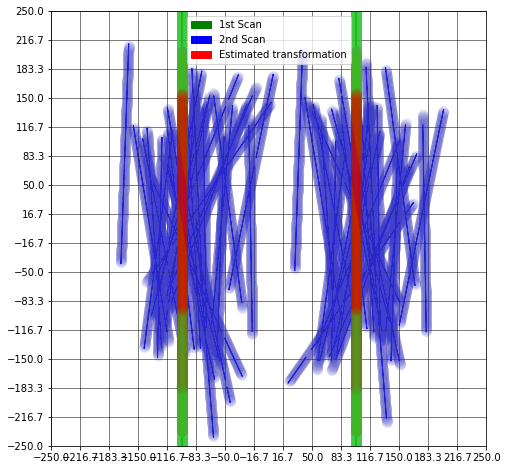

In [2357]:
from ICET import ICET_v2
fig12_2 = plt.figure()
ax12_2 = fig12_2.add_subplot()
ax12_2.set_aspect('equal') 

dat = np.load("data/high_res_noisy_dxdy_100.npy") #default
a = 59            # easy test scans on default dataset: #40 #59 #10 #97 #33 

dat1 = dat[:,:scanpts]
dat2 = dat[:,scanpts:2*scanpts]

green = mpatches.Patch(color='green', label='1st Scan')
blue = mpatches.Patch(color='blue', label='2nd Scan')
red = mpatches.Patch(color='red', label='Estimated transformation')
plt.legend(handles=[green, blue, red])

fidelity = 15     # [N x N] grid of ellipses
nc = 25            # number of cycles
min_num_pts = 30  # minimum number of points per ellipse #works well with 5 for default
atd = True        #along track demo

Epochs = 30
ICET_errors = np.zeros([Epochs,3])
ICET_estimated_errors = np.zeros([Epochs,3])
for i in range(Epochs):
    print("Epoch ", i)
    X, Q, hist, x_actual, condinfo = ICET_v2(dat1[a],dat2[a],fig12_2,ax12_2, fid = fidelity, 
                                              num_cycles = nc, min_num_pts = min_num_pts, 
                                              along_track_demo = atd)
#     print("best transformation X = \n", X.T)
#     print("actual: \n", x_actual)
#     print("Q = \n", Q)
    err = X.T + x_actual
#     print("error: ", err)
    ICET_errors[i,:] = err
    
    #DEBUG: switching up x and y because everything is based off of the minor axis?
#     ICET_estimated_errors[i,0] = np.sqrt(Q[1,1])
#     ICET_estimated_errors[i,1] = np.sqrt(Q[0,0])
    ICET_estimated_errors[i,0] = np.sqrt(Q[0,0])
    ICET_estimated_errors[i,1] = np.sqrt(Q[1,1])
    ICET_estimated_errors[i,2] = np.sqrt(Q[2,2])
    
print("std errors: \n", np.std(ICET_errors, axis = 0))
print("estimated std errors \n", np.mean(ICET_estimated_errors, axis = 0))
# print("estimated std errors: \n", np.std(ICET_estimated_errors, axis =0))

In [2352]:
# ICET_errors_no_outliars = ICET_errors[abs(ICET_errors[:,0]) < 3]
# print(ICET_estimated_errors)
# print(ICET_errors)
print("mean absolute errors:       ", np.mean(abs(ICET_errors), axis =0))

print("actual std (with outliars): ", np.std(ICET_errors, axis = 0))
# print("actual std (no outliars):   ", np.std(ICET_errors_no_outliars, axis =0))
# print(np.shape(ICET_errors_no_outliars))

print("estimated std:              ", np.mean(ICET_estimated_errors, axis = 0))
# print("estimated std errors:       ", np.std(ICET_estimated_errors, axis =0))

#calculate 90th percentile for each of the three parameters 
percentile = 90
x90th = np.percentile(abs(ICET_errors[:,0]),percentile)
x_no_outliars = np.std(ICET_errors[abs(ICET_errors[:,0]) < x90th, 0 ])
y90th = np.percentile(abs(ICET_errors[:,1]),percentile)
y_no_outliars = np.std(ICET_errors[abs(ICET_errors[:,1]) < y90th, 1 ])
theta90th = np.percentile(abs(ICET_errors[:,2]),percentile)
theta_no_outliars = np.std(ICET_errors[abs(ICET_errors[:,2]) < theta90th, 2 ])

ans90th = np.array([x_no_outliars, y_no_outliars, theta_no_outliars])
print("lower ", percentile, "% STD:    ", ans90th          )


mean absolute errors:        [6.27488087e-02 2.34767267e+01 1.11354443e-03]
actual std (with outliars):  [8.25518743e-02 2.92167432e+01 1.49615511e-03]
estimated std:               [1.49632169e-01 3.49709367e+00 2.05410867e-03]
lower  90 % STD:     [6.17762719e-02 2.46154614e+01 1.14000764e-03]


(array([1., 1., 1., 3., 4., 6., 6., 4., 2., 2.]),
 array([-0.00391159, -0.00323543, -0.00255928, -0.00188312, -0.00120696,
        -0.0005308 ,  0.00014535,  0.00082151,  0.00149767,  0.00217383,
         0.00284998]),
 <BarContainer object of 10 artists>)

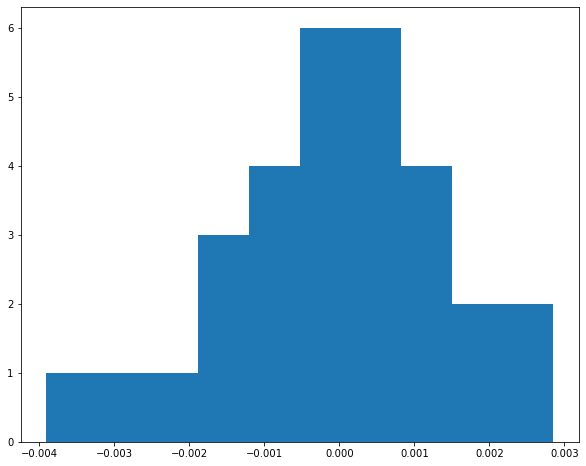

In [2353]:
fig13 = plt.figure()
ax13 = fig13.add_subplot()
# ax13.set_aspect('equal') 
# print(ICET_estimated_errors)
# print(ICET_errors)
# bins = np.linspace(1,100,50)/200 - 0.25; #for ICET_errors[:,2]
ax13.hist(ICET_errors[:,2])

In [1751]:
A = np.identity(2)
A[0,0] = 0.999
A[1,1] = 0.999
A[1,0] = -0.003
A[0,1] = 0.003
print(A)
# print(np.linalg.pinv(A))
# print(A.T)
B = np.array([1,0])
print(B.dot(A))

[[ 0.999  0.003]
 [-0.003  0.999]]
[0.999 0.003]


In [1739]:
C = np.random.randn(2,2)
print("C = \n", C)
print("C.T = \n", C.T)
print("C.H = \n", np.conj(C).T)


C = 
 [[ 0.91100245  1.11161246]
 [ 0.3323429  -1.69006848]]
C.T = 
 [[ 0.91100245  0.3323429 ]
 [ 1.11161246 -1.69006848]]
C.H = 
 [[ 0.91100245  0.3323429 ]
 [ 1.11161246 -1.69006848]]


In [1931]:
test = np.identity(4)
test[0,0] = 4
test[1,0] = 3
test[0,1] = 2
test[2,3] = 9
test[3,2] = -11
print(test)
print(np.linalg.pinv(test))

test2 = np.array([[4,2],
                  [3,1]])
print("test2: \n", test2)
print(np.linalg.pinv(test2))

print(np.linalg.pinv(test[:2,:2]) == np.linalg.pinv(test2))

[[  4.   2.   0.   0.]
 [  3.   1.   0.   0.]
 [  0.   0.   1.   9.]
 [  0.   0. -11.   1.]]
[[-0.5   1.    0.    0.  ]
 [ 1.5  -2.    0.    0.  ]
 [ 0.    0.    0.01 -0.09]
 [ 0.    0.    0.11  0.01]]
test2: 
 [[4 2]
 [3 1]]
[[-0.5  1. ]
 [ 1.5 -2. ]]
[[ True  True]
 [ True  True]]


## Proof that (H.T)(W)(H) = (U)(lam)(U.T)

In [932]:
from utils import *

H_temp = np.random.rand(6,3)
W_temp = np.identity(6)
arr = H_temp.T.dot(W_temp).dot(H_temp)

print("arr: \n", arr)
eig = np.linalg.eig(arr)
eigenval = eig[0][:,None]
eigenvec = eig[1]

print("eigenvec: \n", eigenvec)
# print("eigenval: \n", eigenval)

lam = np.identity(3)
for i in range(3):
    lam[i,i] = eigenval[i]

print("lam: \n", lam)
    
print("ans: \n", eigenvec.dot(lam).dot(eigenvec.T))


arr: 
 [[0.77747327 1.14813026 0.85809418]
 [1.14813026 3.86871894 2.48112066]
 [0.85809418 2.48112066 1.89827578]]
eigenvec: 
 [[ 0.26684726  0.91398909 -0.30564109]
 [ 0.7956562  -0.38788648 -0.46526904]
 [ 0.54380488  0.11902946  0.83072754]]
lam: 
 [[5.94954345 0.         0.        ]
 [0.         0.40197019 0.        ]
 [0.         0.         0.19295435]]
ans: 
 [[0.77747327 1.14813026 0.85809418]
 [1.14813026 3.86871894 2.48112066]
 [0.85809418 2.48112066 1.89827578]]


In [933]:
# from scipy import misc

#not going to work with our inputs

def f(x):
    #works
    return(np.sin(x+1)/4)
    
def NewtonsMethod(f, x, tolerance=0.001):
    while True:
        x1 = x - f(x) / misc.derivative(f, x) 
        t = abs(x1 - x)
        if t < tolerance:
            break
        x = x1
    return x

x = 3

x0 = NewtonsMethod(f, x)
print(x0)

2.1418041869523385


In [34]:
#ellipse z score equation

pt_x = 1
pt_y = 1.5

major = 1.94 #20
minor = 1.166 #12

ratio = major / minor

print("inside if < 1: ", (pt_x**2)/(minor**2) + (pt_y**2)/(major**2))

b = np.sqrt( (pt_x**2)/(ratio**2) + pt_y**2 )
print(b)
a = ratio*b
print(a)

print("z-score: ", a/major)

inside if < 1:  1.3333661110554416
1.6159326026212426
2.6886014143097863
z-score:  1.385877017685457


In [35]:
from ICET import get_U_and_L

ctr1 = np.zeros([len(E1),2])
cov1 = np.zeros([len(E1),2,2])
npts1 = np.zeros(len(E1))
for idx1, c1 in enumerate(E1):
    ctr1[idx1,:] = c1[0]
    cov1[idx1,:] = c1[1]
    
U, L = get_U_and_L(cov1)
print("U[:3] = \n", U[:3], "\n L = \n", L, np.shape(L))

Using cellsize =  [50. 50.]
U[:3] = 
 [[[ 0.00387902 -0.99999248]
  [ 0.99999248  0.00387902]]

 [[ 0.01188518 -0.99992937]
  [ 0.99992937  0.01188518]]

 [[-0.0033979  -0.99999423]
  [ 0.99999423 -0.0033979 ]]] 
 L = 
 [array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 0],
       [0, 1]]), array([[1, 

In [ ]:
np.linalg.pinv(np.array([[0,1],[0,1]]))

In [ ]:
from ICET import fast_weighted_psudoinverse

inpoints = np.reshape(pp1, (np.shape(pp1)[0]*2,1), order='C')

print(np.shape(inpoints))
fast_weighted_psudoinverse(inpoints,np.array([1,1,1]))

### Differentiation tests

In [ ]:
# import tensorflow as tf
# tf.compat.v1.enable_eager_execution()

# x = tf.constant([[3.0, 4.0, 10.0, 100.]])

# with tf.GradientTape() as grad:
#     grad.watch(x)
#     y = x * x
    
# dy_dx = grad.gradient(y,x)
# print(dy_dx.numpy())

# H = tf.hessians(ys, xs, gate_gradients=False, aggregation_method=None)
# print(H)

#--------------------------------------------

# import numpy as np
# # def f(x,y):
# #     return np.sin((x + y))
# # x = y = np.arange(-5, 5, 0.05)

# x = np.random.rand(3)
# y = np.random.rand(3)

# X, Y = np.meshgrid(x, y)
# print(X,"\n", Y)

# zs = np.array([f(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
# Z = zs.reshape(X.shape)

# gx,gy = np.gradient(Z,0.05,0.05)

# print("gx: \n", gx, "\n gy: \n",gy)
#-------------------------------------------------------
import numpy as np

# arr = np.random.rand(3,3)
arr = np.linspace(0,4,5)
arr = np.array([arr,2*arr])
print("input array: \n", arr)

d1 = np.gradient(arr)
print("df/dy \n",d1[0])
print("df/dx \n", d1[1])

d2f_dx = np.gradient(d1[1])
print("d2f_dxdy \n", d2f_dx[0])
print("d2f_d2x \n", d2f_dx[1]) 

d2f_dy = np.gradient(d1[0])
print("d2f_dydx \n", d2f_dy[1])
print("d2f_d2y \n", d2f_dy[0]) 

#order of partials does not matter...
# print(d2f_dx[0] == d2f_dy[1])


In [ ]:
l1 = np.zeros([2,2])
l2 = np.ones(2)

a = []
a.append(l1)
a.append(l2)
print(a)

In [ ]:
a = np.array([[1,0]])
np.shape(a)

### Notes:

- ICET is very sensitive to voxel size:
        
            increasing voxel size can cause multiple objects to be grouped within the same ellipse, this will cause the ellipse to be rotated not in the direction of geometric ambiguity of each individual shape but merely be rotated to represent the spatial relationship between the two objects
            
            
- much better results when dividing cellsize by 2 (may be due to radius/ diameter inconsistancy)

### Questions:

- what do I do if BOTH axis of ellipse extend past the cutoff value?

- both pure cross track and pure along track will explode in some situations 

- do conditioning on each summand of first term (H_i.T)(W_i)(H_i) or at the end? 
        
        - I'm assuming the end...

- when removing axis after calculting condition number how do I know which axis are associated with each eigenvalue?

        - should I be using an identity matrix or should I just use whatever axis the eig() function puts out eigenvectors

- is the goal of the 2nd L matrix to avoid explosion or to encourage convergence? 



In [ ]:
#test
x = -np.linspace(0,10,11)
A, B, C = sorted(x)[0:3]
print(x)
print(A, B, C)

In [ ]:
np.linalg.pinv(np.identity(1))